# CA2 PART A - Stock Price Forecasting
*** 

In [1]:
# Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import itertools

import warnings
warnings.filterwarnings('ignore')

# Split the data into train-test data
from sklearn.model_selection import train_test_split

# Seasonal component
from statsmodels.tsa.seasonal import seasonal_decompose

# Granger's Test for Causality
from statsmodels.tsa.stattools import grangercausalitytests

# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

# To do differencing to convert into stationary time series
from statsmodels.tsa.statespace.tools import diff

# To do Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# To do Arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Model evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from math import sqrt

# Loading the csv as a dataset
stockPrice_df = pd.read_csv("../CA2/Datasets/CA2-Stock-Price-Data.csv")

## Analysing the stockprice dataset

In [2]:
# Setting up a copy for EDA
stockPrice_df_eda = stockPrice_df.copy()

# Show the head of the dataset
print("Showing the first 10 rows of the dataset:")
print(stockPrice_df_eda.head(10))
print("\nShowing the last 10 rows of the dataset:")
print(stockPrice_df_eda.tail(10))

Showing the first 10 rows of the dataset:
         Date      Apple      Amazon        DBS
0   10/1/2018  56.814999  100.218002  25.969999
1   10/2/2018  57.320000   98.565498  25.629999
2   10/3/2018  58.017502   97.638000  25.950001
3   10/4/2018  56.997501   95.471001  25.760000
4   10/5/2018  56.072498   94.482498  25.770000
5   10/8/2018  55.942501   93.221001  25.469999
6   10/9/2018  56.717499   93.515999  25.260000
7  10/10/2018  54.090000   87.762497  24.950001
8  10/11/2018  53.612499   85.968002  24.309999
9  10/12/2018  55.527500   89.430496  24.420000

Showing the last 10 rows of the dataset:
           Date       Apple      Amazon        DBS
1247  9/15/2023  175.009995  140.389999  34.240002
1248  9/18/2023  177.970001  139.979996  34.230000
1249  9/19/2023  179.070007  137.630005  33.830002
1250  9/20/2023  175.490005  135.289993  33.680000
1251  9/21/2023  173.929993  129.330002  33.220001
1252  9/22/2023  174.789993  129.119995  33.250000
1253  9/25/2023  176.080002  13

***
From this, we can see that the dates go through 5 days before skipping 2 dates. This shows that the date frequency is in Business Days, 'B'. We would need to set the specified frequency as 'B' in the later steps.
***

In [3]:
stockPrice_df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1257 non-null   object 
 1   Apple   1257 non-null   float64
 2   Amazon  1257 non-null   float64
 3   DBS     1257 non-null   float64
dtypes: float64(3), object(1)
memory usage: 39.4+ KB


***
From this, we can see that only date column is an object and the rest are float64 type. This means that we would need to turn the date into a date dtype later on. The other values do not need to be changed.
***

In [4]:
stockPrice_df_eda.shape

(1257, 4)

***
From this, we can see that there is 1257 rows and 4 columns in our dataset.
***

In [5]:
stockPrice_df_eda.describe()

Apple       Amazon          DBS
count  1257.000000  1257.000000  1257.000000
mean    116.168385   124.791237    28.185863
std      46.945568    32.495925     4.738732
min      35.547501    67.197998    16.879999
25%      66.592499    93.489998    24.879999
50%     129.610001   120.970001    28.650000
75%     152.589996   158.100494    32.480000
max     196.449997   186.570496    37.250000

***
This describes the basic statistics of the dataset, showing some important components such as mean, std, 25% and 75%.
***

## Preprocessing / Cleaning the dataset

### Converting the date column into the desired format and frequency

In [6]:
# Making a copy of the dataset
stockPriceDateEdited_df = stockPrice_df.copy()

# Converting to datetime format
stockPriceDateEdited_df['Date'] = pd.to_datetime(stockPriceDateEdited_df['Date'])
stockPriceDateEdited_df.set_index('Date', inplace=True)

# Setting the frequency to business day frequency 'B'
stockPriceDateEdited_df = stockPriceDateEdited_df.asfreq('B')

# Showing the results
print(stockPriceDateEdited_df)

                 Apple      Amazon        DBS
Date                                         
2018-10-01   56.814999  100.218002  25.969999
2018-10-02   57.320000   98.565498  25.629999
2018-10-03   58.017502   97.638000  25.950001
2018-10-04   56.997501   95.471001  25.760000
2018-10-05   56.072498   94.482498  25.770000
...                ...         ...        ...
2023-09-22  174.789993  129.119995  33.250000
2023-09-25  176.080002  131.270004  33.450001
2023-09-26  171.960007  125.980003  33.509998
2023-09-27  170.429993  125.980003  33.430000
2023-09-28  170.690002  125.980003  33.500000

[1304 rows x 3 columns]


***
We have just converted the date into the correct format and set the frequency of the timeseries to 'B'.
***

### Checking and resolving NaN values

In [7]:
# Display the count of NaN values before handling NaN values
print("Before handling NaN values:")
print(stockPriceDateEdited_df.isna().sum())

# Use bfill to fill NaN values in each column separately
stockPriceDateEdited_df['Apple'].fillna(method='bfill', inplace=True)
stockPriceDateEdited_df['Amazon'].fillna(method='bfill', inplace=True)
stockPriceDateEdited_df['DBS'].fillna(method='bfill', inplace=True)

# Display the count of NaN values after handling NaN values using bfill
print("\nAfter handling NaN values using bfill:")
print(stockPriceDateEdited_df.isna().sum())

Before handling NaN values:
Apple     47
Amazon    47
DBS       47
dtype: int64

After handling NaN values using bfill:
Apple     0
Amazon    0
DBS       0
dtype: int64


***
From this, we can see that there is initially 47 NaN values from each company stock. We then resolved the NaN values by using bfill, which would help to bettter preserve the trend that stock prices would usually have.
***

### Correlations

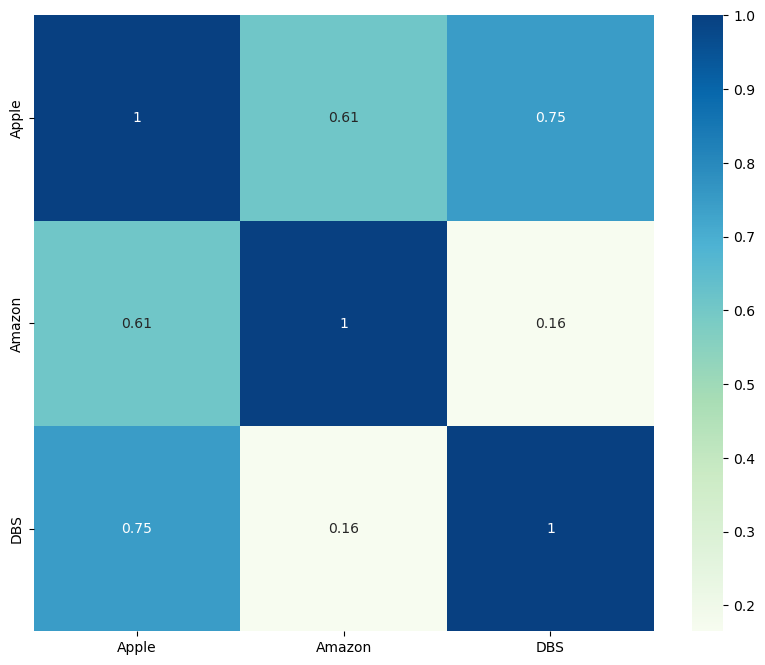

In [8]:
plt.figure(figsize=(10,8))
sns.heatmap(stockPriceDateEdited_df.corr(), annot=True, cmap="GnBu")
plt.show()

***
How to read:
- 1 indicates a perfect positive correlation
- -1 indicates a perfect negative correlation
- 0 indicates no correlation

From this we can see that:
- Apple and Amazon, Apple and DBS have a strong positive correlation with each other.
- Amazon and DBS have a weak positive correlation with each other.
***

### Granger's Test for Causality

          Apple_x  Amazon_x   DBS_x
Apple_y    1.0000    0.0857  0.0672
Amazon_y   0.0150    1.0000  0.0207
DBS_y      0.0001    0.0002  1.0000


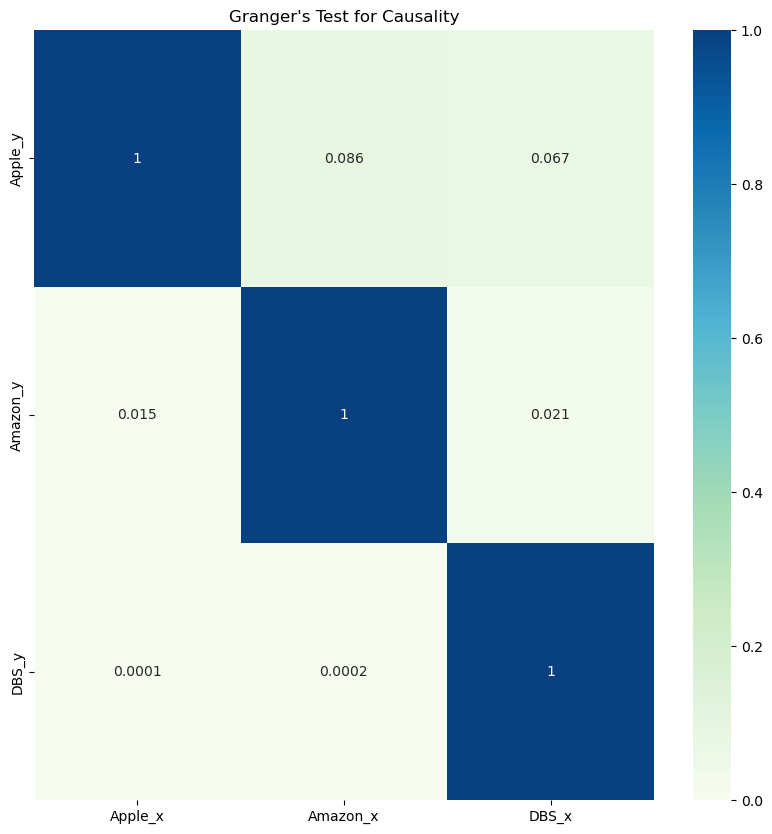

In [9]:
maxlag = 12
test = "ssr_chi2test"

g_matrix = pd.DataFrame(
    np.zeros((len(stockPriceDateEdited_df.columns), len(stockPriceDateEdited_df.columns))),
    columns=stockPriceDateEdited_df.columns,
    index=stockPriceDateEdited_df.columns,
)

for c in g_matrix.columns:
    for r in g_matrix.index:
        test_result = grangercausalitytests(
            stockPriceDateEdited_df[[r, c]], maxlag=maxlag, verbose=False
        )
        p_values = [round(test_result[i + 1][0][test][1], 4) for i in range(maxlag)]
        min_p_value = np.min(p_values)
        g_matrix.loc[r, c] = min_p_value

g_matrix.columns = [var + "_x" for var in stockPriceDateEdited_df.columns]
g_matrix.index = [var + "_y" for var in stockPriceDateEdited_df.columns]

print(g_matrix)

plt.figure(figsize=(10, 10))
sns.heatmap(g_matrix, annot=True, cmap="GnBu", vmin=0, vmax=1)
plt.title("Granger's Test for Causality")
plt.show()

***
The granger test score for Apple against Amazon and DBS is more than that the significant value of 0.05.

This shows that there is no granger casual relationship between Amazon and Apple, and DBS and Apple.

However, the granger test score for Amazon against Apple and DBS, and DBS against Apple and Amazon is less than the significant value of 0.05.

This shows that there is a granger casual relationship between Apple and Amazon, DBS and Amazon, Apple and DBS, Amazon and DBS.
***

## Seasonal component

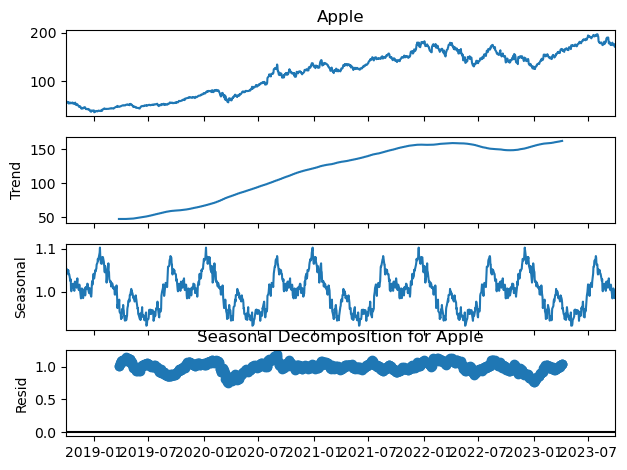

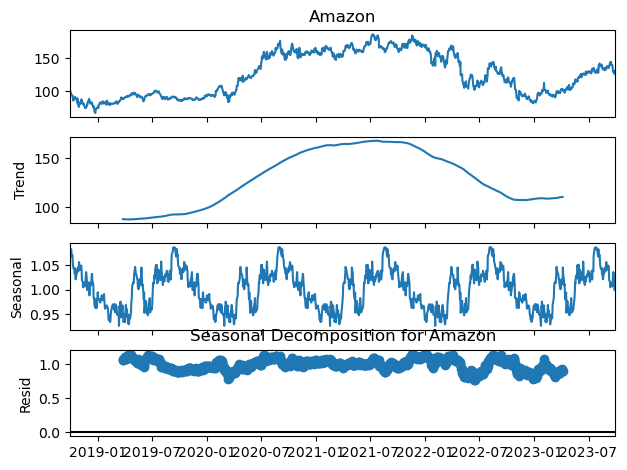

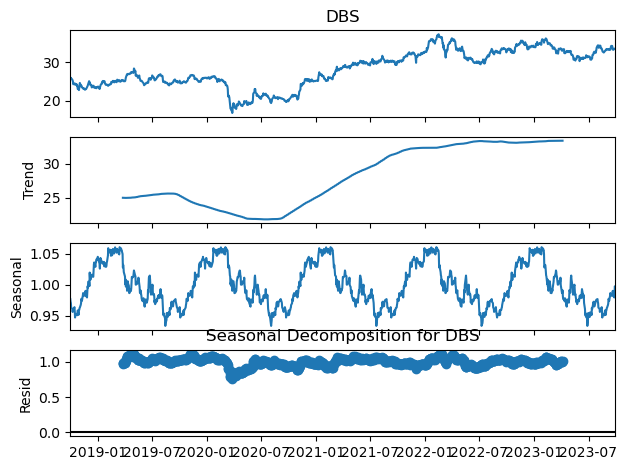

In [10]:
# Make a copy of the dataset
df_decompose = stockPriceDateEdited_df.copy()

# Iterate over columns in the DataFrame
for i in df_decompose.columns:
    # Perform seasonal decomposition
    results = seasonal_decompose(df_decompose[i], model="multiplicative", period=252)

    # Plot the results
    results.plot()
    plt.title(f"Seasonal Decomposition for {i}")
    plt.show()

***
Seasonal Decomposition will give 3 outputs:

- Original Time Series: 
    - This is the raw data, often plotted as a line graph, showing the observed values over time. It may exhibit trends, seasonal patterns, and irregular fluctuations.

- Trend Component: 
    - The trend component represents the long-term movement or direction of the data. It smooths out short-term fluctuations and highlights the underlying pattern. In the plot, this component is usually shown as a smooth line or curve.

- Seasonal Component: 
    - The seasonal component captures the periodic patterns or fluctuations that occur within a specific period, such as daily, monthly, or yearly cycles. This component reveals regular patterns that repeat over a fixed interval of time. In the plot, the seasonal component is typically depicted as a repeating pattern or curve that follows the same cycle across different time periods.

- Residual Component (Irregular or Noise): 
    - The residual component, also known as the irregular or noise component, represents the remaining variability in the data that cannot be explained by the trend or seasonal components. It consists of random fluctuations, outliers, and other unpredictable variations. In the plot, the residual component is often shown as the difference between the original data and the sum of the trend and seasonal components.

The seasonal_decompose() function can take in two types of models:
- Additive
    - Linear
    - For Stationary Datasets
- Multiplicative
    - Non-Linear
    - For Non Stationary Datasets

In many time series involving big quantities (e.g. money, stocks), the absolute difference in values is of less interest rather than the percentage changes. This is a  where multiplicative method is used.

In multiplicative time series, the magnitude of both the seasonal and random components increase as the level of trend increases.

Analysing the graphs:

- For Apple:
    - Apple: This is the original data, which is likely a time series of some metric related to Apple. The line increases overall from left to right, indicating growth or improvement over time.
    - Trend: This graph shows the trend component extracted from the original data. It’s a smoother line that also shows an upward trend over time, indicating a long-term increase in the metric being measured.
    - Seasonal: This graph represents the seasonal fluctuations extracted from the original data. The line has peaks and troughs, indicating that there are regular patterns that repeat over time. These could be due to seasonal factors like quarterly earnings reports, product release cycles, or market trends.
    - Resid: This graph shows the residual component, which is what remains after the trend and seasonal components have been removed from the original data. These residuals represent the unexplained or irregular fluctuations in the data.

- For Amazon:
    - Amazon: This is the original data in a time series format. The line fluctuates and increases overall from left to right, indicating growth or improvement over time.
    - Trend: This displays the trend component extracted from the original data. It’s a smoother line indicating an upward trend over time. There is a large increase followed by a large decrease, yet the overall is still an increase.
    - Seasonal: This represents the seasonal fluctuations extracted from the original data. The line has peaks and troughs, indicating that there are regular patterns that repeat over time. These could be due to seasonal factors like quarterly earnings reports, product release cycles, or market trends.
    - Resid: This shows the residual component, which is what remains after the trend and seasonal components have been removed from the original data. These residuals represent the unexplained or irregular fluctuations in the data.

- For DBS:
    - DBS: This is the original data in a time series format. The line fluctuates and increases overall from left to right, indicating growth or improvement over time.
    - Trend: This displays the trend component extracted from the original data. It’s a smoother line indicating an upward trend over time. There is a decrease before a increase.
    - Seasonal: This represents the seasonal fluctuations extracted from the original data. The line has peaks and troughs, indicating that there are regular patterns that repeat over time. These could be due to seasonal factors like quarterly earnings reports, product release cycles, or market trends.
    - Resid: This shows the residual component, which is what remains after the trend and seasonal components have been removed from the original data. These residuals represent the unexplained or irregular fluctuations in the data.
***

## Checking for time series stationarity

### Visual check on plots to check for stationarity

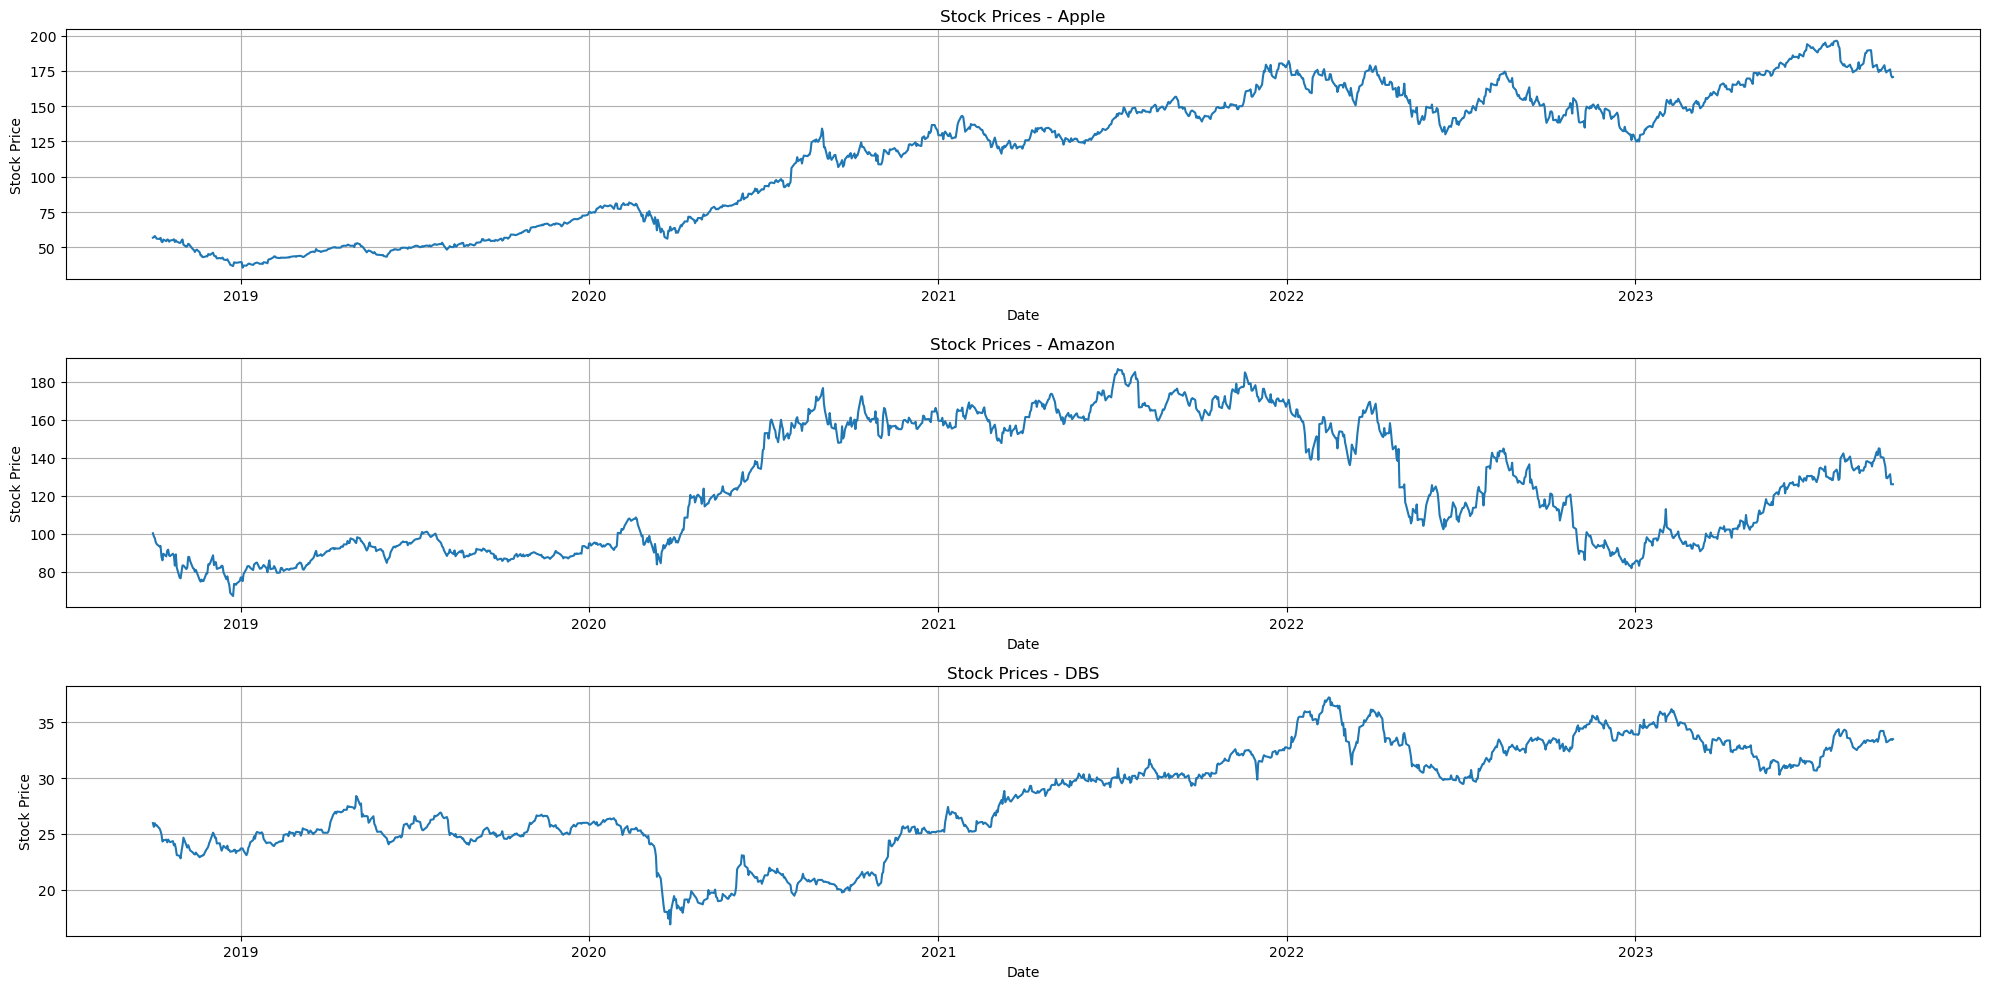

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10), tight_layout=True)

for i, stock in enumerate(["Apple", "Amazon", "DBS"]):
    sns.lineplot(data=stockPriceDateEdited_df, x='Date', y=stock, ax=ax[i])
    ax[i].set_title(f'Stock Prices - {stock}')
    ax[i].set_xlabel('Date')
    ax[i].set_ylabel('Stock Price')
    ax[i].grid(True)  # Add grid lines

plt.show()

***
From the graphs above, we can see that: 
- There are a lot of spikes which means that there is a very high variance in stock prices of Apple, Amazon and DBS.
- There is not much of a trend for the 3 graphs.
- There is a general increasing trend in the long run of the stock price of all 3 companies (Apple, Amazon, DBS).
- We can also observe that the companies have different stock price ranges as seen from the different range of y-axis.
- The datas are also taken over the same timeframe of over several years (2018-10-01 to 2023-09-28)

Therefore, the 3 time series might not be stationary. However, visualizaion of trends is not a good indicator of whether it is stationary. Hence, we would be conducting other tests to check for stationary.
***

### Summary Statistics to check for stationarity

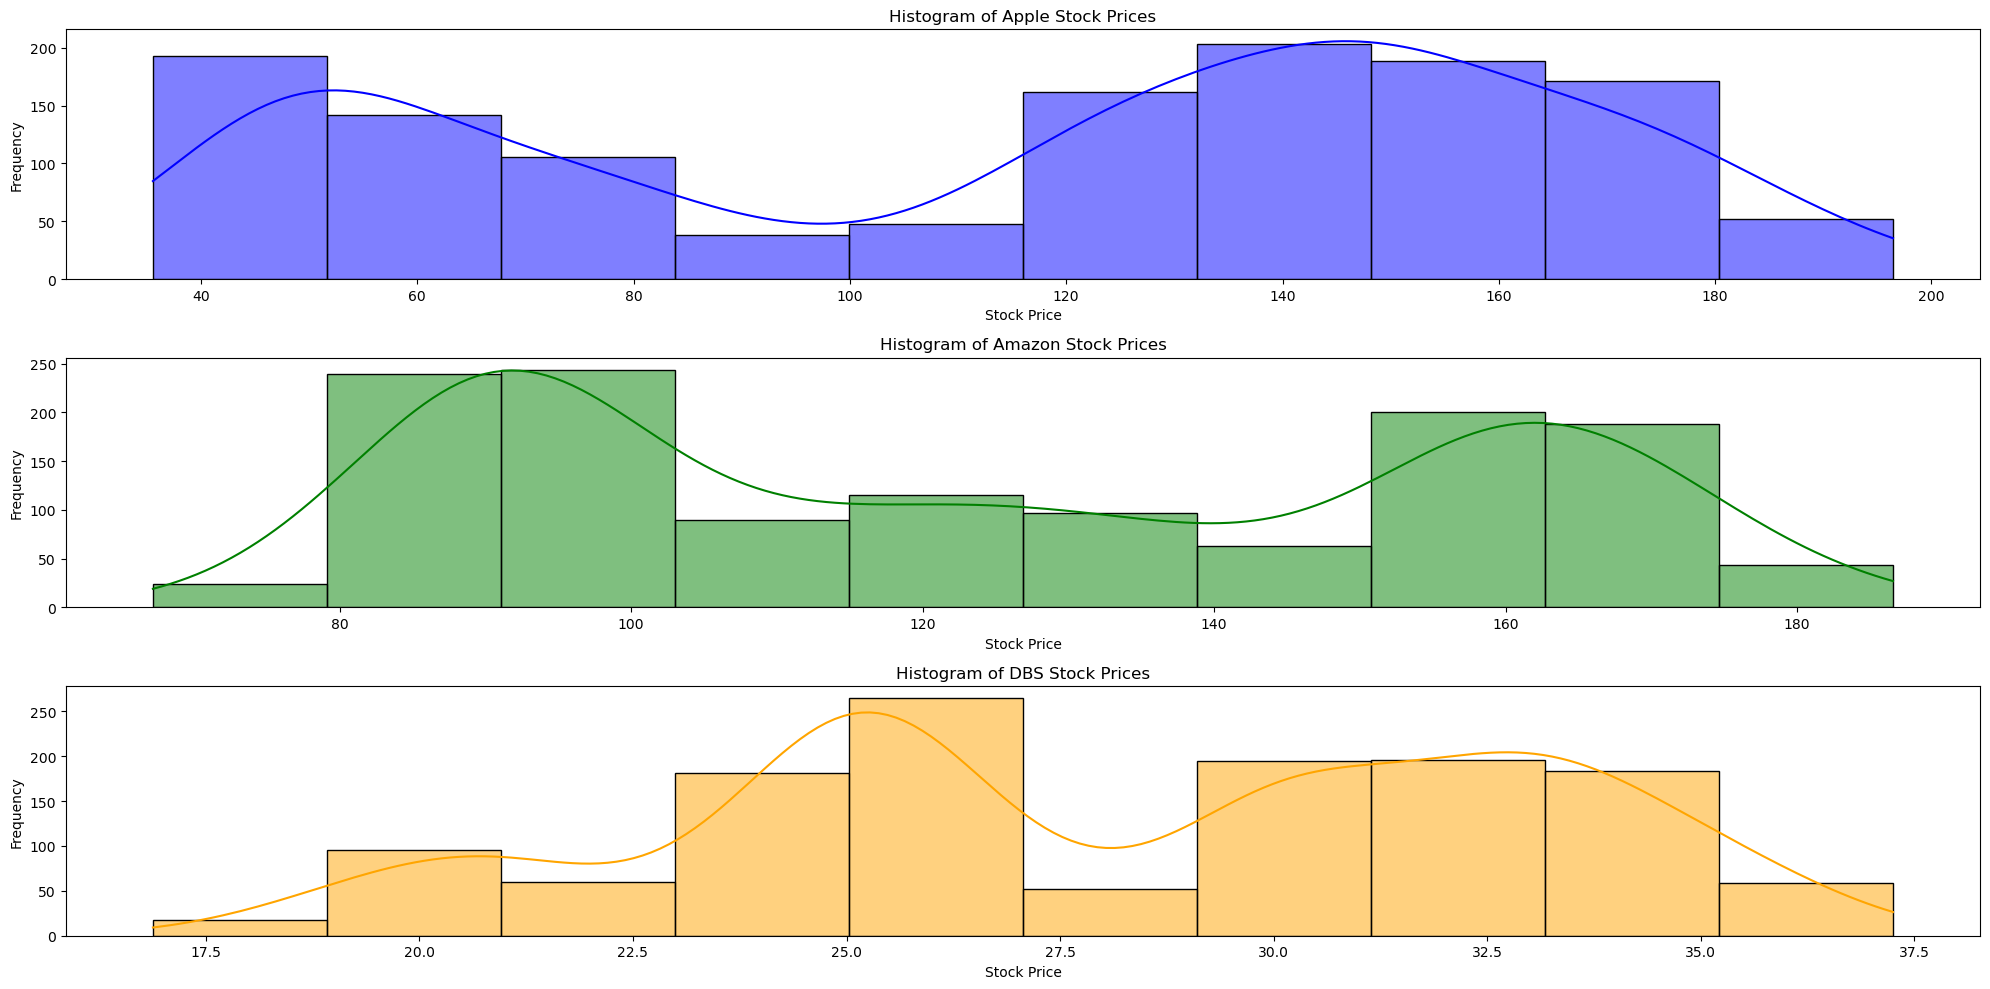

In [12]:
# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 10))

# Plotting the Apple stock prices
sns.histplot(stockPriceDateEdited_df['Apple'], bins=10, kde=True, color='blue', ax=axes[0])
axes[0].set_title('Histogram of Apple Stock Prices')
axes[0].set_xlabel('Stock Price')
axes[0].set_ylabel('Frequency')

# Plotting the Amazon stock prices
sns.histplot(stockPriceDateEdited_df['Amazon'], bins=10, kde=True, color='green', ax=axes[1])
axes[1].set_title('Histogram of Amazon Stock Prices')
axes[1].set_xlabel('Stock Price')
axes[1].set_ylabel('Frequency')

# Plotting the DBS stock prices
sns.histplot(stockPriceDateEdited_df['DBS'], bins=10, kde=True, color='orange', ax=axes[2])
axes[2].set_title('Histogram of DBS Stock Prices')
axes[2].set_xlabel('Stock Price')
axes[2].set_ylabel('Frequency')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

***
From the graphs above, we can see that:
- Apple stock price is skewed to the left.
- Amazon stock price is skewed to the right.
- DBS stock price is skewed to the left.

There is not really a normal distribution observed in any of the stock prices for the 3 companies.

If the time series is stationary, the data should conform to Gaussian distribution (bell curve). Since none of the data conform to a bellshape curve, none of the data are stationary.
***

In [13]:
# Create a copy of the dataset
stockPriceDateSplit_df = stockPriceDateEdited_df.copy()

# Separate the data for each stock
X1 = stockPriceDateSplit_df['Apple'][:len(stockPriceDateSplit_df)//2]
X2 = stockPriceDateSplit_df['Apple'][len(stockPriceDateSplit_df)//2:]

X3 = stockPriceDateSplit_df['Amazon'][:len(stockPriceDateSplit_df)//2]
X4 = stockPriceDateSplit_df['Amazon'][len(stockPriceDateSplit_df)//2:]

X5 = stockPriceDateSplit_df['DBS'][:len(stockPriceDateSplit_df)//2]
X6 = stockPriceDateSplit_df['DBS'][len(stockPriceDateSplit_df)//2:]

# Print summary statistics for each stock
print(f'For Apple stock, group 1 mean = {X1.mean():.2f}, group 2 mean = {X2.mean():.2f}, \n'
      f'group 1 variance = {X1.var():.2f}, group 2 variance = {X2.var():.2f}')

print()

print(f'For Amazon stock, group 1 mean = {X3.mean():.2f}, group 2 mean = {X4.mean():.2f}, \n'
      f'group 1 variance = {X3.var():.2f}, group 2 variance = {X4.var():.2f}')

print()

print(f'For DBS stock, group 1 mean = {X5.mean():.2f}, group 2 mean = {X6.mean():.2f}, \n'
      f'group 1 variance = {X5.var():.2f}, group 2 variance = {X6.var():.2f}')

For Apple stock, group 1 mean = 76.41, group 2 mean = 155.79, 
group 1 variance = 955.09, group 2 variance = 309.22

For Amazon stock, group 1 mean = 113.31, group 2 mean = 136.01, 
group 1 variance = 1008.80, group 2 variance = 851.13

For DBS stock, group 1 mean = 24.03, group 2 mean = 32.35, 
group 1 variance = 6.16, group 2 variance = 4.03


***
For a stationary time series, they should always have the same mean and variance values. Since there is a large difference between the mean and variance values of group 1 and group 2 of all stocks, none of the time series are stationary.
***

### Statistical Test - ADF (Augmented Dickey Fuller) Test

In [14]:
# Perform ADF test for each column
result_apple = adfuller(stockPriceDateEdited_df['Apple'])
result_amazon = adfuller(stockPriceDateEdited_df['Amazon'])
result_dbs = adfuller(stockPriceDateEdited_df['DBS'])

# Print p-values
print('Apple Dataset p-value: %f' % result_apple[1])
print('Amazon Dataset p-value: %f' % result_amazon[1])
print('DBS Dataset p-value: %f' % result_dbs[1])

Apple Dataset p-value: 0.770732
Amazon Dataset p-value: 0.460098
DBS Dataset p-value: 0.641780


***
- P-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- P-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

Conclusion after ADF:
- Apple has a p-value > 0.05 which means the data has a unit root and is non-stationary.
- Amazon has a p-value < 0.05 which means the data does not have a unit root and is stationary.
- DBS has a p-value > 0.05 which means the data has a unit root and is non-stationary.
***

## Making the time series stationary by differencing

Apple Stock Price before differencing p-value: 0.770732
Apple Stock Price after first differencing p-value: 0.000000
Amazon Stock Price before differencing p-value: 0.460098
Amazon Stock Price after first differencing p-value: 0.000000


DBS Stock Price before differencing p-value: 0.641780
DBS Stock Price after first differencing p-value: 0.000000


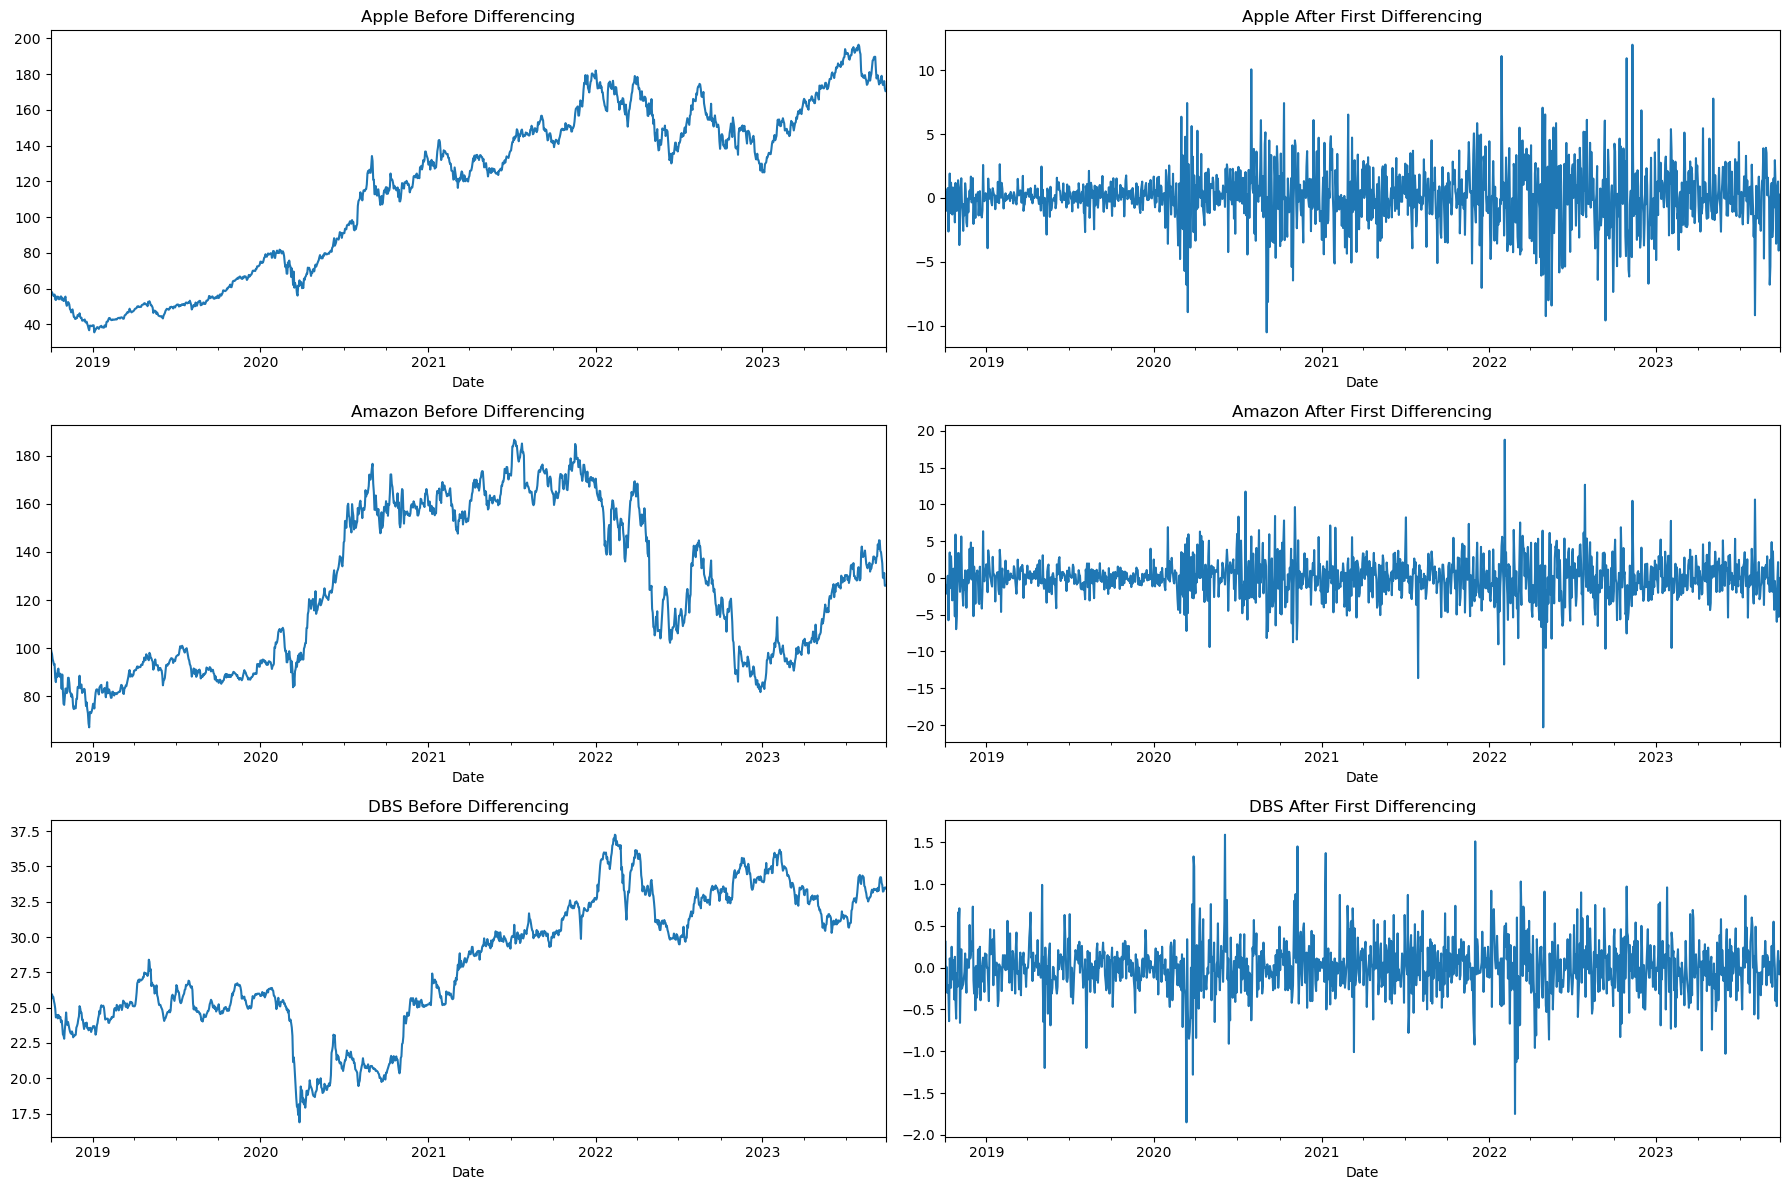

In [15]:
# Create a copy of the dataset
stockPriceDateStationary_df = stockPriceDateEdited_df.copy()

# First Differencing for Apple
df_diff1_apple = stockPriceDateStationary_df['Apple'].diff().dropna()
result1_apple = adfuller(stockPriceDateStationary_df['Apple'])
result_diff1_apple = adfuller(df_diff1_apple)

print('Apple Stock Price before differencing p-value: %f' % result1_apple[1])
print('Apple Stock Price after first differencing p-value: %f' % result_diff1_apple[1])

# First Differencing for Amazon
df_diff1_amazon = stockPriceDateStationary_df['Amazon'].diff().dropna()
result1_amazon = adfuller(stockPriceDateStationary_df['Amazon'])
result_diff1_amazon = adfuller(df_diff1_amazon)

print('Amazon Stock Price before differencing p-value: %f' % result1_amazon[1])
print('Amazon Stock Price after first differencing p-value: %f' % result_diff1_amazon[1])

# First Differencing for DBS
df_diff1_dbs = stockPriceDateStationary_df['DBS'].diff().dropna()
result1_dbs = adfuller(stockPriceDateStationary_df['DBS'])
result_diff1_dbs = adfuller(df_diff1_dbs)

print('DBS Stock Price before differencing p-value: %f' % result1_dbs[1])
print('DBS Stock Price after first differencing p-value: %f' % result_diff1_dbs[1])

# Plotting
fig, axes = plt.subplots(3, 2, figsize=(18, 12))

# Apple
stockPriceDateStationary_df['Apple'].plot(ax=axes[0, 0], title='Apple Before Differencing')
df_diff1_apple.plot(ax=axes[0, 1], title='Apple After First Differencing')

# Amazon
stockPriceDateStationary_df['Amazon'].plot(ax=axes[1, 0], title='Amazon Before Differencing')
df_diff1_amazon.plot(ax=axes[1, 1], title='Amazon After First Differencing')

# DBS
stockPriceDateStationary_df['DBS'].plot(ax=axes[2, 0], title='DBS Before Differencing')
df_diff1_dbs.plot(ax=axes[2, 1], title='DBS After First Differencing')

plt.tight_layout()
plt.show()

***
From above, we have successfully make the timeseries stationary for use. We have used only first differencing as after first differencing, P-value <= 0.05. We will then reject the null hypothesis (H0) showing that the data does not have a unit root and is now stationary.
***

## Splitting the data into training and test data

In [16]:
# Assuming business day frequency
stockPriceDateStationary_df.index = pd.to_datetime(stockPriceDateStationary_df.index, format='%m/%d/%Y')
df = stockPriceDateStationary_df.asfreq('B')

# Fill or interpolate missing values
df = df.interpolate(method='linear')

# Splitting the data into training and testing sets based on a specific date
train_data = df[df.index < '2023-07-30']
test_data = df[df.index >= '2023-07-30']

# Calculate the length of the training data
train_size = len(train_data)

# Split the dataset into training and testing sets
y_train, y_test = df[:train_size], df[train_size:]

# Print the shapes of the training and testing sets
print(f"y train shape: {y_train.shape}")
print(f"y test shape: {y_test.shape}")

y train shape: (1260, 3)
y test shape: (44, 3)


***
I will be splitting my data into till 60 days before the end of the dataset which is 2023-07-30 for training, and after 2023-07-30 which is 60 days for testing and forecasting. Splitting data into training and testing is important to allow models to test on unseen data to see how it fares.
***

## Performing time series forecasting

### Building a simple moving average model

#### Without test-train

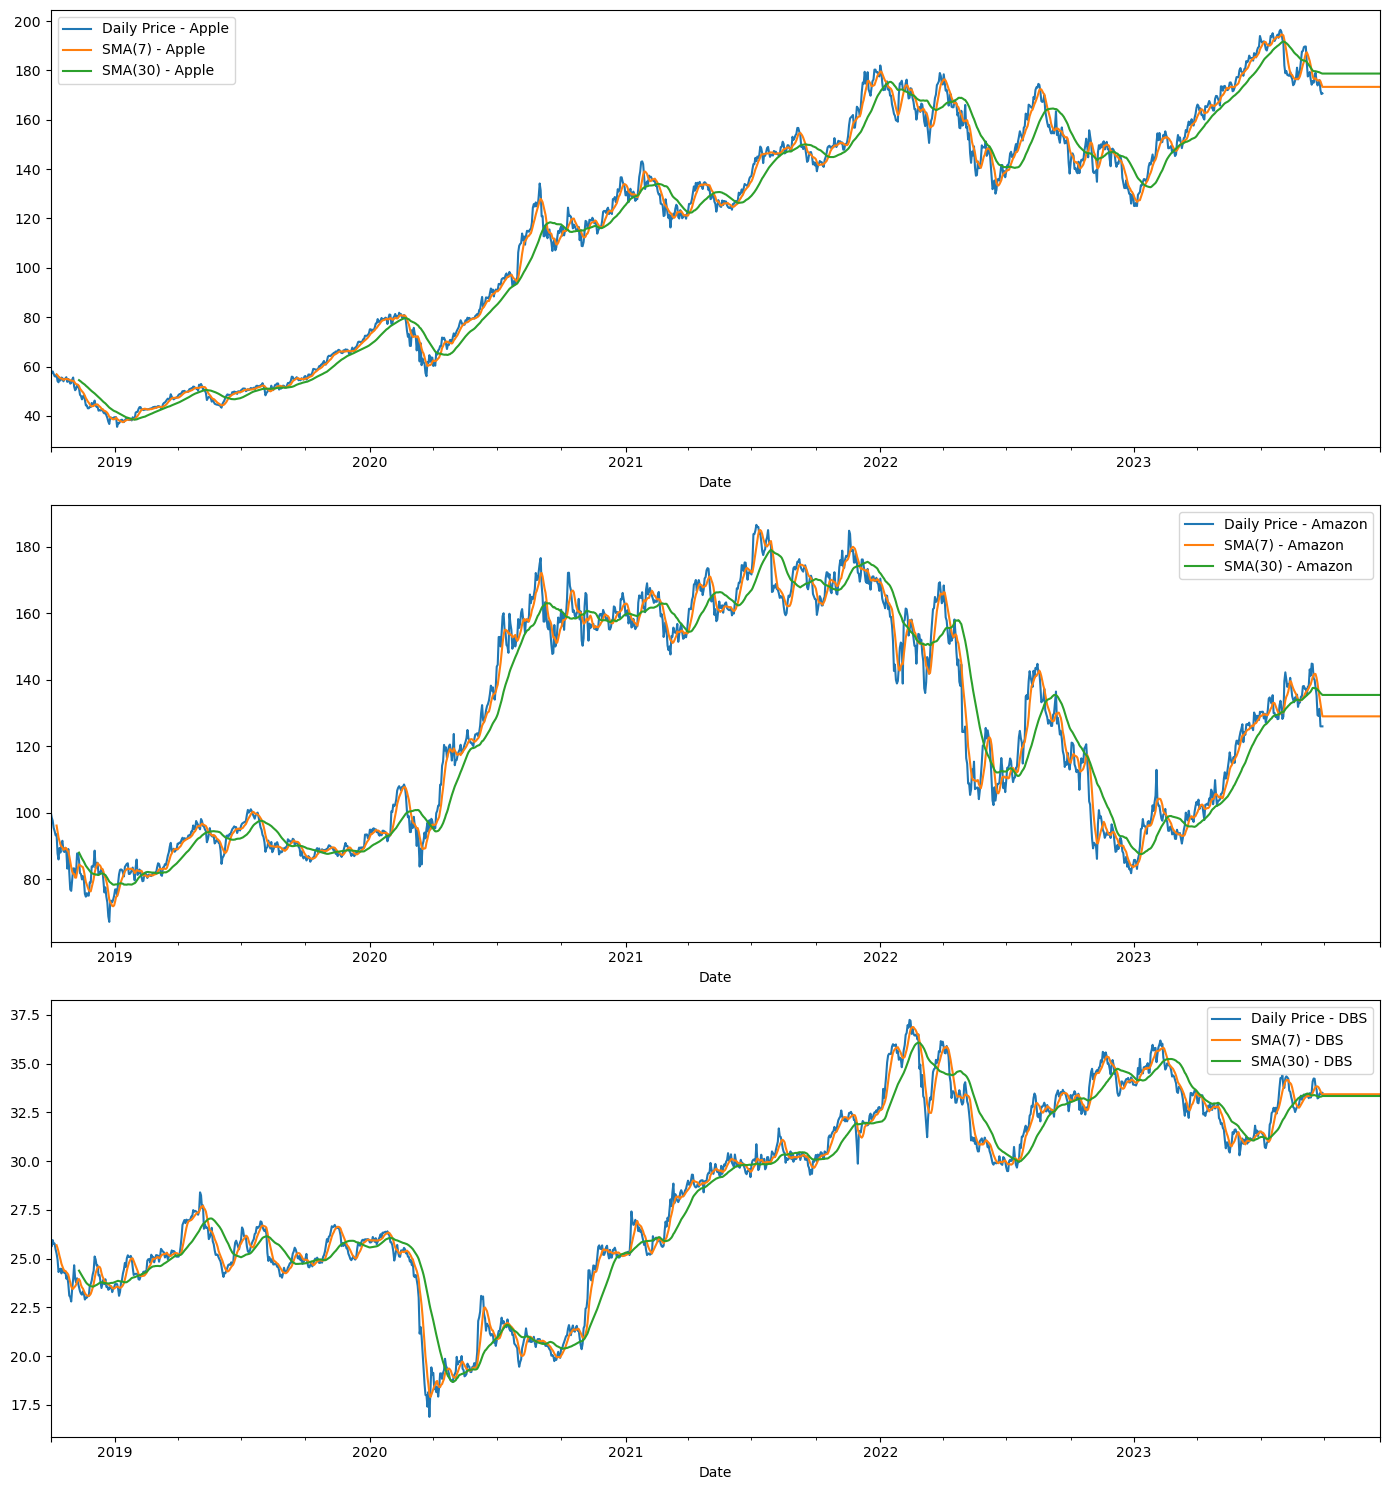

In [17]:
# Create a copy of the DataFrame for SMA forecasting
stockPriceDateSMA_df = stockPriceDateStationary_df.copy()

# Calculate SMA(7) and SMA(30) for each stock
sma_7 = stockPriceDateSMA_df.rolling(window=7).mean()
sma_30 = stockPriceDateSMA_df.rolling(window=30).mean()

# Extend the SMA values into the future by 60 days
future_dates = pd.date_range(start=stockPriceDateSMA_df.index[-1], periods=60, freq='B')[1:]
future_sma_7 = pd.DataFrame(index=future_dates, columns=stockPriceDateSMA_df.columns)
future_sma_30 = pd.DataFrame(index=future_dates, columns=stockPriceDateSMA_df.columns)

for column in stockPriceDateSMA_df.columns:
    future_sma_7[column] = sma_7[column].iloc[-1]
    future_sma_30[column] = sma_30[column].iloc[-1]

# Concatenate SMA dataframes with the original dataframes
extended_sma_7 = pd.concat([sma_7, future_sma_7])
extended_sma_30 = pd.concat([sma_30, future_sma_30])

# Plotting
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 15))

# Plot Apple
stockPriceDateSMA_df['Apple'].plot(ax=axes[0], label='Daily Price - Apple')
extended_sma_7['Apple'].plot(ax=axes[0], label='SMA(7) - Apple')
extended_sma_30['Apple'].plot(ax=axes[0], label='SMA(30) - Apple')
axes[0].legend()

# Plot Amazon
stockPriceDateSMA_df['Amazon'].plot(ax=axes[1], label='Daily Price - Amazon')
extended_sma_7['Amazon'].plot(ax=axes[1], label='SMA(7) - Amazon')
extended_sma_30['Amazon'].plot(ax=axes[1], label='SMA(30) - Amazon')
axes[1].legend()

# Plot DBS
stockPriceDateSMA_df['DBS'].plot(ax=axes[2], label='Daily Price - DBS')
extended_sma_7['DBS'].plot(ax=axes[2], label='SMA(7) - DBS')
extended_sma_30['DBS'].plot(ax=axes[2], label='SMA(30) - DBS')
axes[2].legend()

plt.tight_layout()
plt.show()

***
- Daily Price (Blue Line): This line indicates the fluctuations in the daily stock prices over time.
- SMA-17 (Orange Line): This line represents a shorter-term simple moving average calculated over 17 periods. It’s a smoothed line that helps identify the direction of the trend over a shorter period.
- SMA-30 (Green Line): This line indicates a longer-term simple moving average calculated over 30 periods. It helps identify the direction of the trend over a longer period.
***

#### With test train

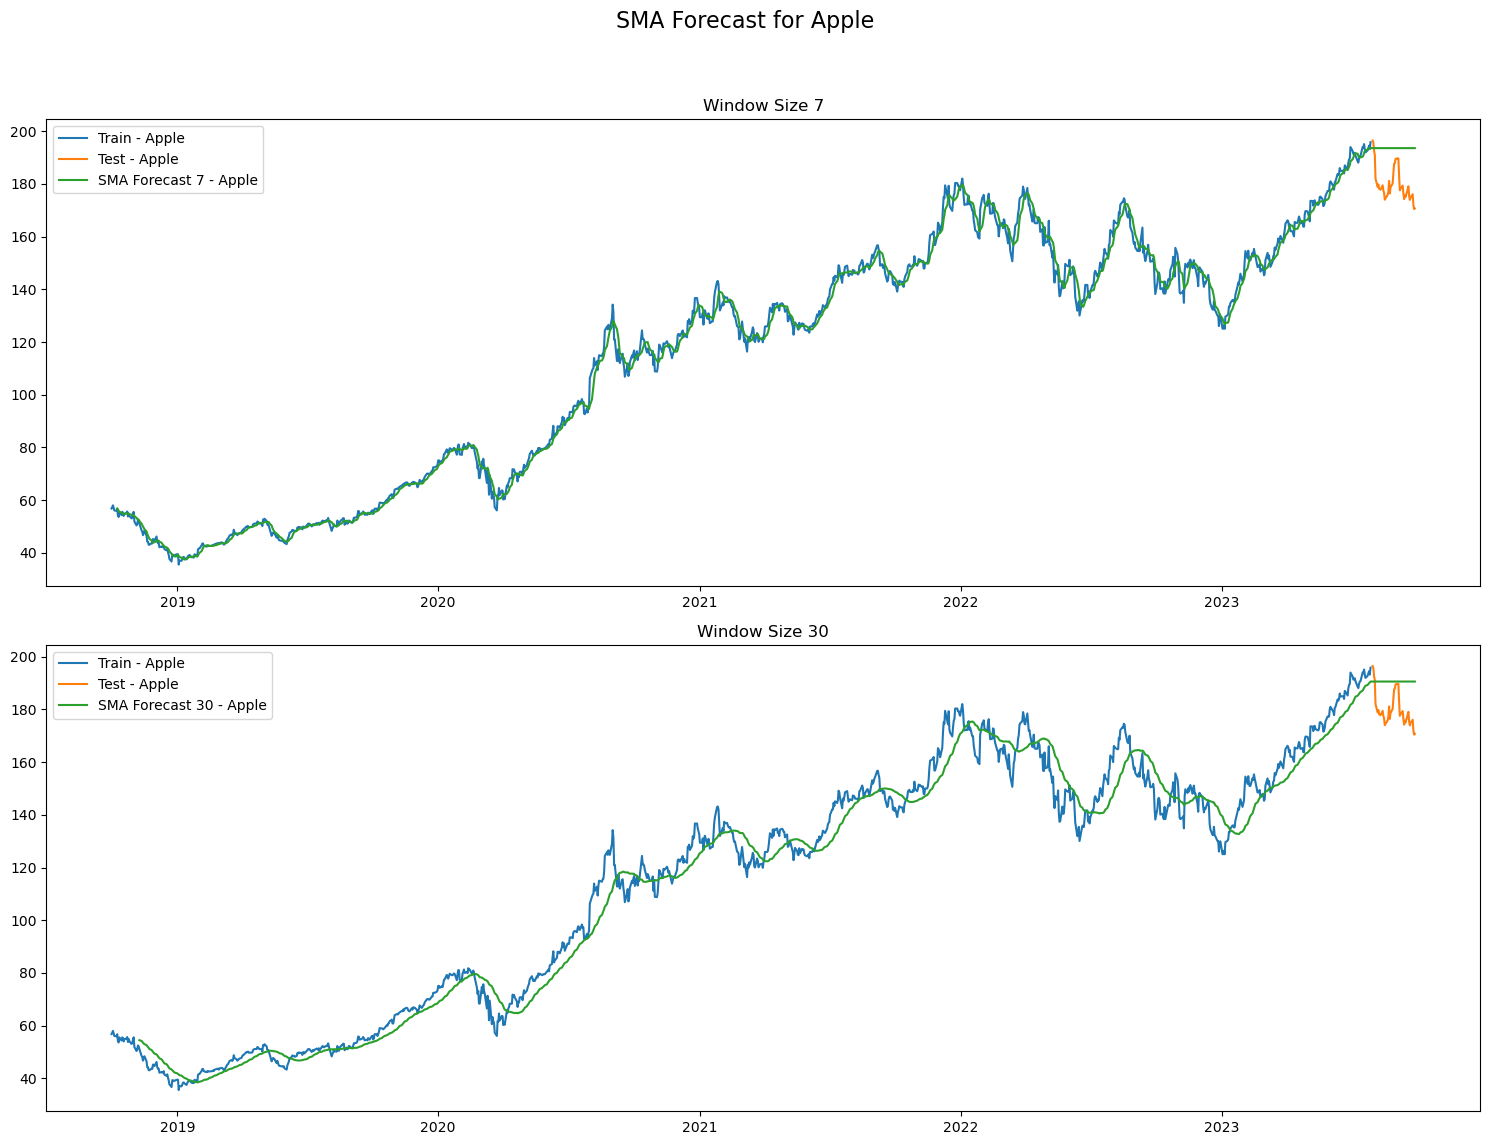

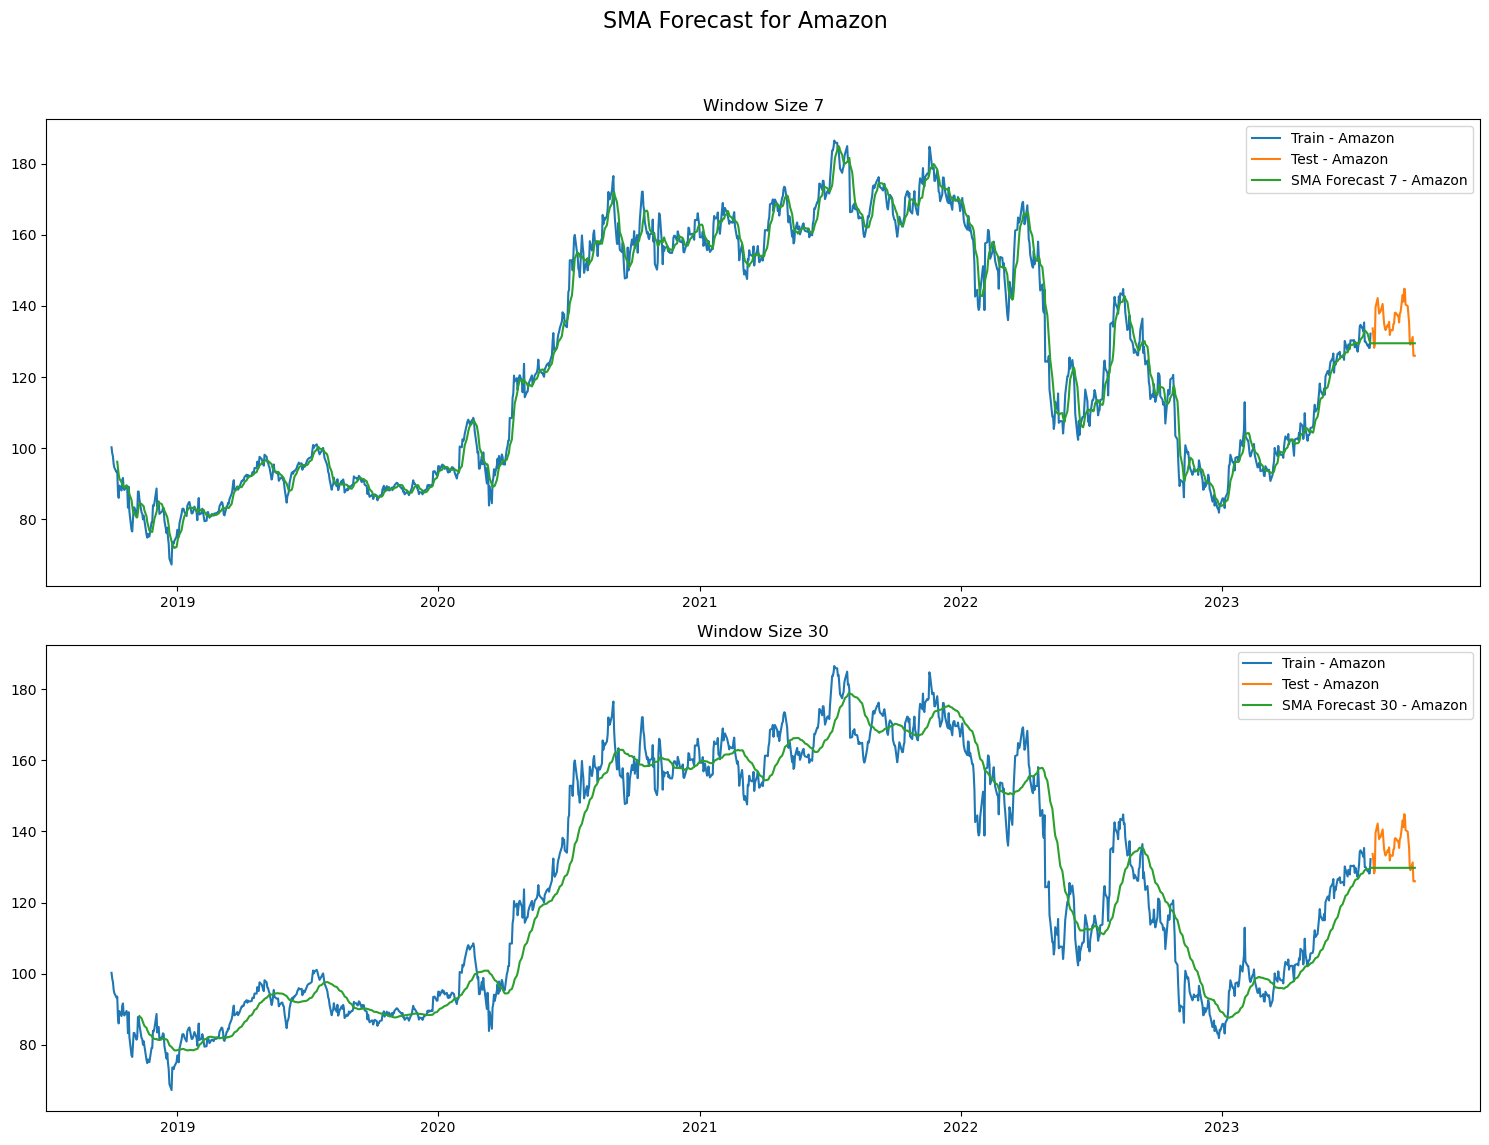

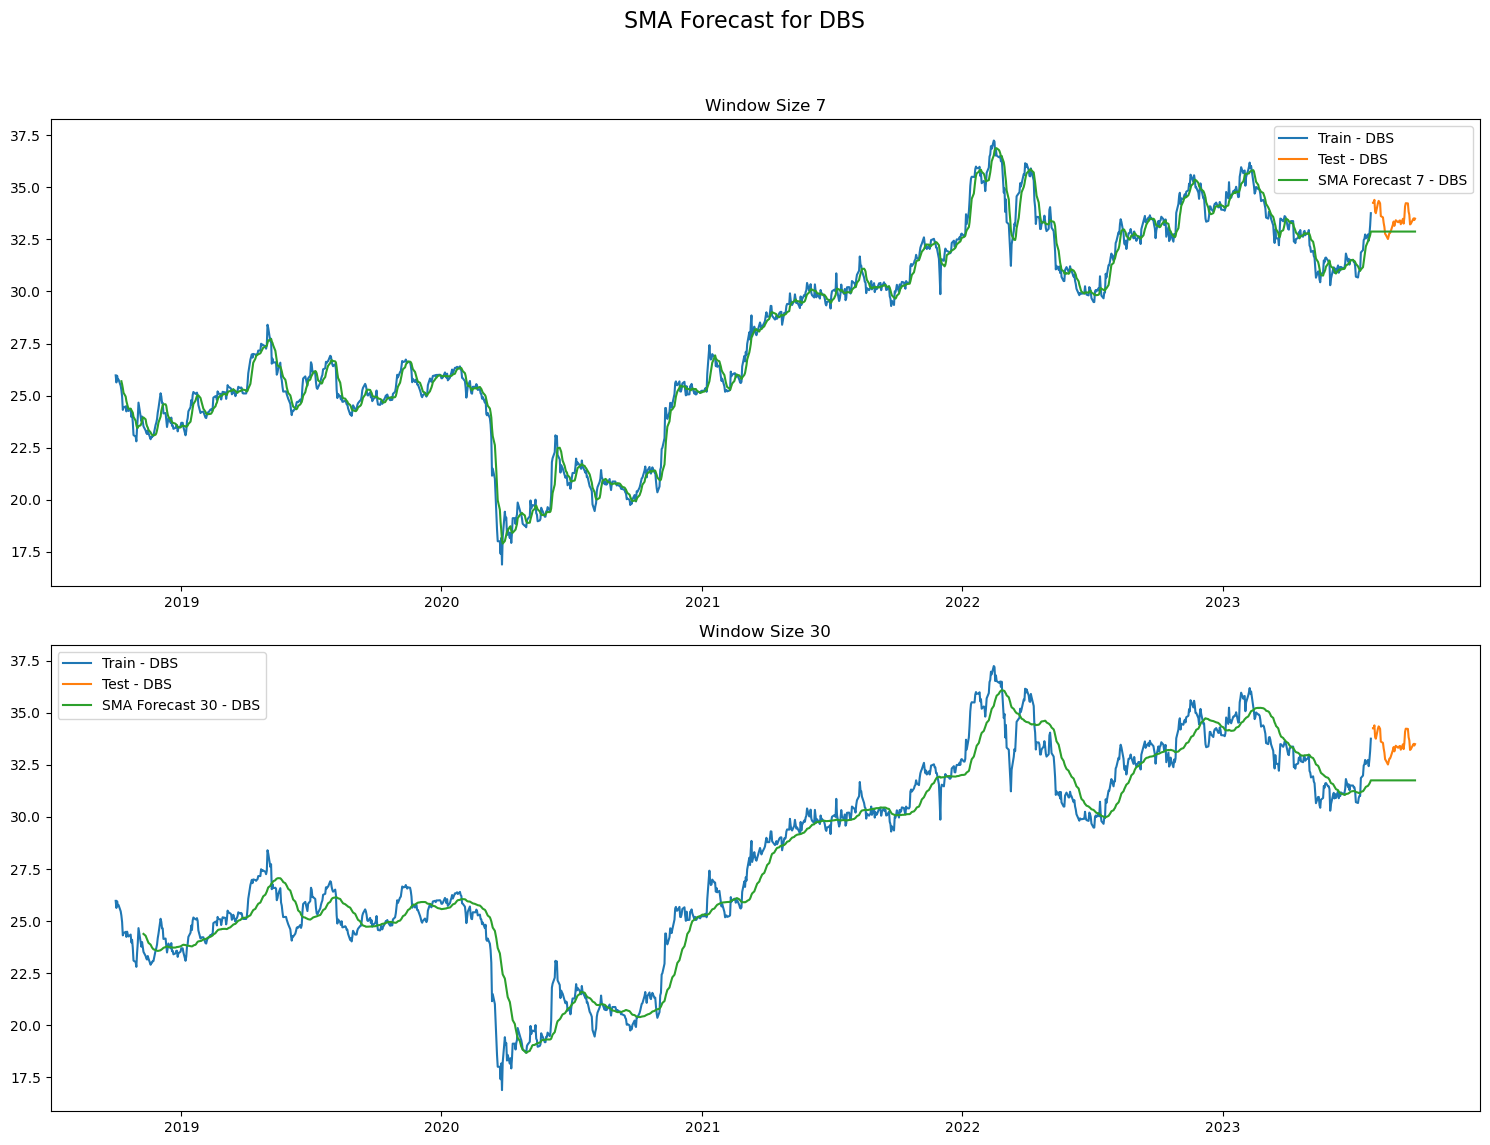

Apple Stock, Window Size=7
RMSE: 15.0127
MAPE: 7.79%
Apple Stock, Window Size=30
RMSE: 12.3619
MAPE: 6.32%
Amazon Stock, Window Size=7
RMSE: 7.7852
MAPE: 4.89%
Amazon Stock, Window Size=30
RMSE: 7.5825
MAPE: 4.76%
DBS Stock, Window Size=7
RMSE: 0.8057
MAPE: 1.99%
DBS Stock, Window Size=30
RMSE: 1.8195
MAPE: 5.20%


In [18]:
# Create a copy of the DataFrame for SMA forecasting
stockPriceDateSMA_df = stockPriceDateStationary_df.copy()

# Update window sizes
window_sizes = [7, 30]

# Plotting
for stock in ['Apple', 'Amazon', 'DBS']:
    plt.figure(figsize=(15, 12))
    plt.suptitle(f"SMA Forecast for {stock}", fontsize=16)

    for i, ma_window in enumerate(window_sizes, 1):
        plt.subplot(len(window_sizes), 1, i)
        plt.plot(y_train[stock], label=f'Train - {stock}')
        plt.plot(y_test[stock], label=f'Test - {stock}')

        sma_column = f'SMA_Forecast_{stock}_{ma_window}'
        stockPriceDateSMA_df[sma_column] = stockPriceDateSMA_df[stock].rolling(ma_window).mean()
        stockPriceDateSMA_df[sma_column][train_size:] = stockPriceDateSMA_df[sma_column][train_size - 1]
        plt.plot(stockPriceDateSMA_df[sma_column], label=f'SMA Forecast {ma_window} - {stock}')

        plt.legend(loc="best")
        plt.title(f"Window Size {ma_window}")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Evaluating
for stock in ['Apple', 'Amazon', 'DBS']:
    for ma_window in window_sizes:
        sma_column = f'SMA_Forecast_{stock}_{ma_window}'
        actual_values = stockPriceDateStationary_df[stock][train_size:]
        forecasted_values = stockPriceDateSMA_df[sma_column][train_size:]

        mae = mean_absolute_error(actual_values, forecasted_values)
        mse = mean_squared_error(actual_values, forecasted_values)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((actual_values - forecasted_values) / actual_values)) * 100

        print(f"{stock} Stock, Window Size={ma_window}")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAPE: {mape:.2f}%")


***
RMSE (Root Mean Square Error): This metric measures the average magnitude of the errors between predicted values and actual values. It gives us a sense of how spread out the errors are. Lower RMSE indicates better accuracy.

MAPE (Mean Absolute Percentage Error): MAPE measures the size of the error as a percentage of the actual value. It gives us an idea of the accuracy of the model in terms of percentage of error relative to the actual values. Lower MAPE indicates better accuracy.

- Apple Stock:
    - For a window size of 7 days, the RMSE is 15.0127 and the MAPE is 7.79%.
    - For a window size of 30 days, the RMSE is 12.3619 and the MAPE is 6.32%.
    - The RMSE decreases slightly when using a larger window size, indicating better performance in terms of prediction accuracy. However, the MAPE remains relatively stable.

- Amazon Stock:
    - For a window size of 7 days, the RMSE is 7.7852 and the MAPE is 4.89%.
    - For a window size of 30 days, the RMSE is 7.5825 and the MAPE is 4.76%.
    - Interestingly, in the case of Amazon stock, the RMSE decreases slightly when using a larger window size, indicating better performance in terms of prediction accuracy. Additionally, the MAPE also decreases, suggesting lower prediction errors relative to the actual values.

- DBS Stock:
    - For a window size of 7 days, the RMSE is 0.8057 and the MAPE is 1.99%.
    - For a window size of 30 days, the RMSE is 1.8195 and the MAPE is 5.20%.
    - For DBS stock, both RMSE and MAPE are very low compared to Apple and Amazon. There is a slight increase in RMSE and MAPE when using a larger window size.

In summary:

- For Apple stock, increasing the window size leads to a slight improvement in RMSE with a negligible change in MAPE.
- For Amazon stock, increasing the window size slightly improves the RMSE and MAPE.
- For DBS stock, increasing the window size slightly deproves the RMSE and MAPE.

However, the SMA method is a simple and intuitive approach, but it has limitations. It may not capture complex patterns or changes in the underlying data. It also gives equal weight to all data points within the window, which may not be suitable for all time series. Therefore, we would need to use other advanced methods like exponential smoothing, ARIMA or SARIMA to overcome these limitations and provide more accurate forecasts.
***

### Building a exponential smoothing model

#### Holt-Winters Seasonal Method on test-train data

c:\Users\caleb\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


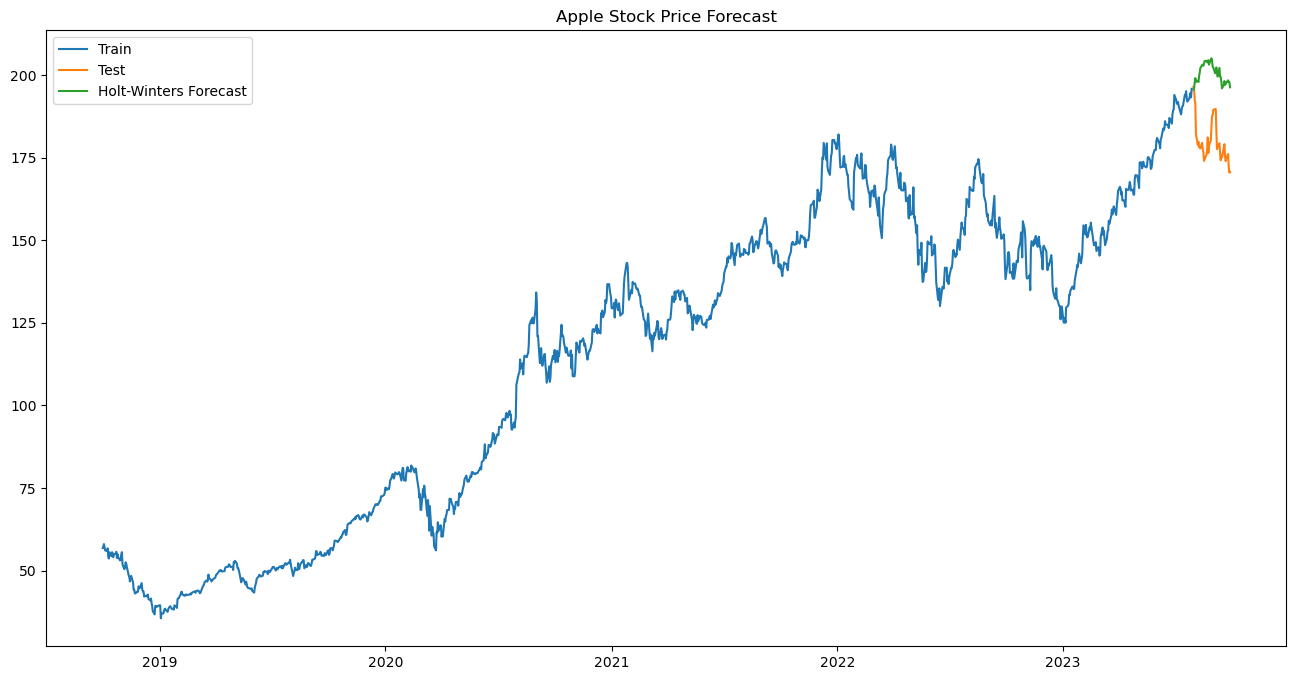

c:\Users\caleb\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


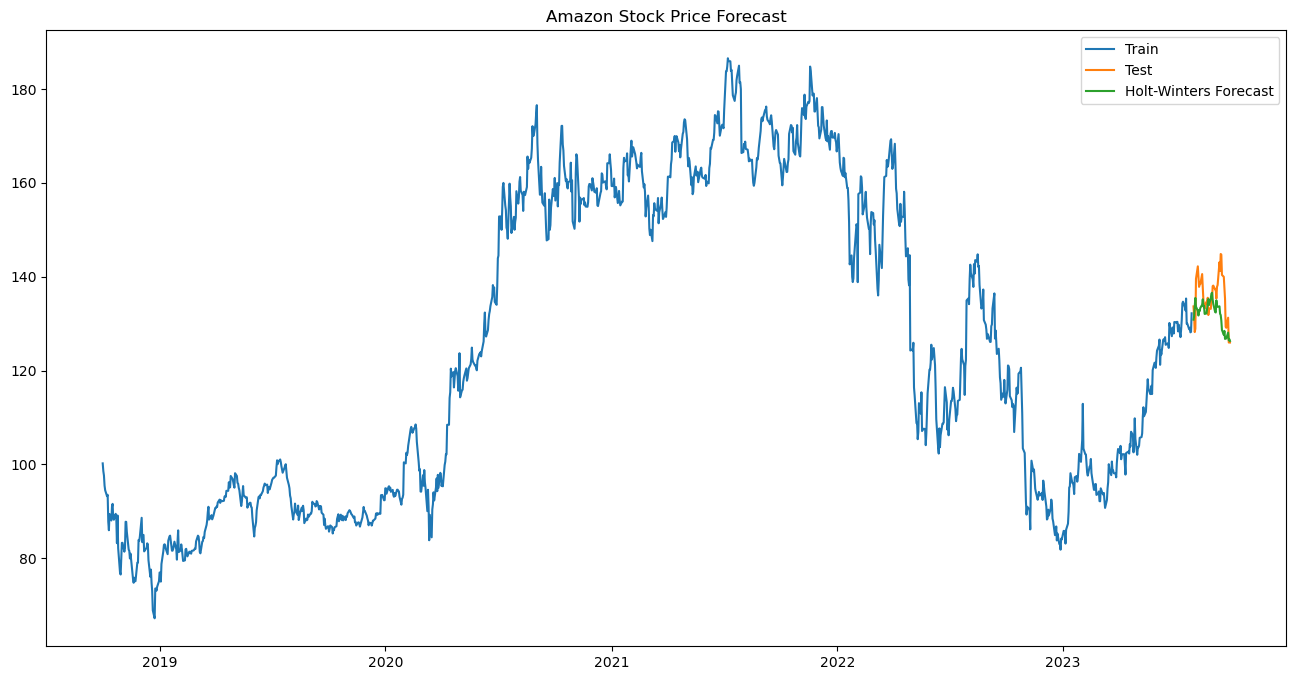

c:\Users\caleb\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


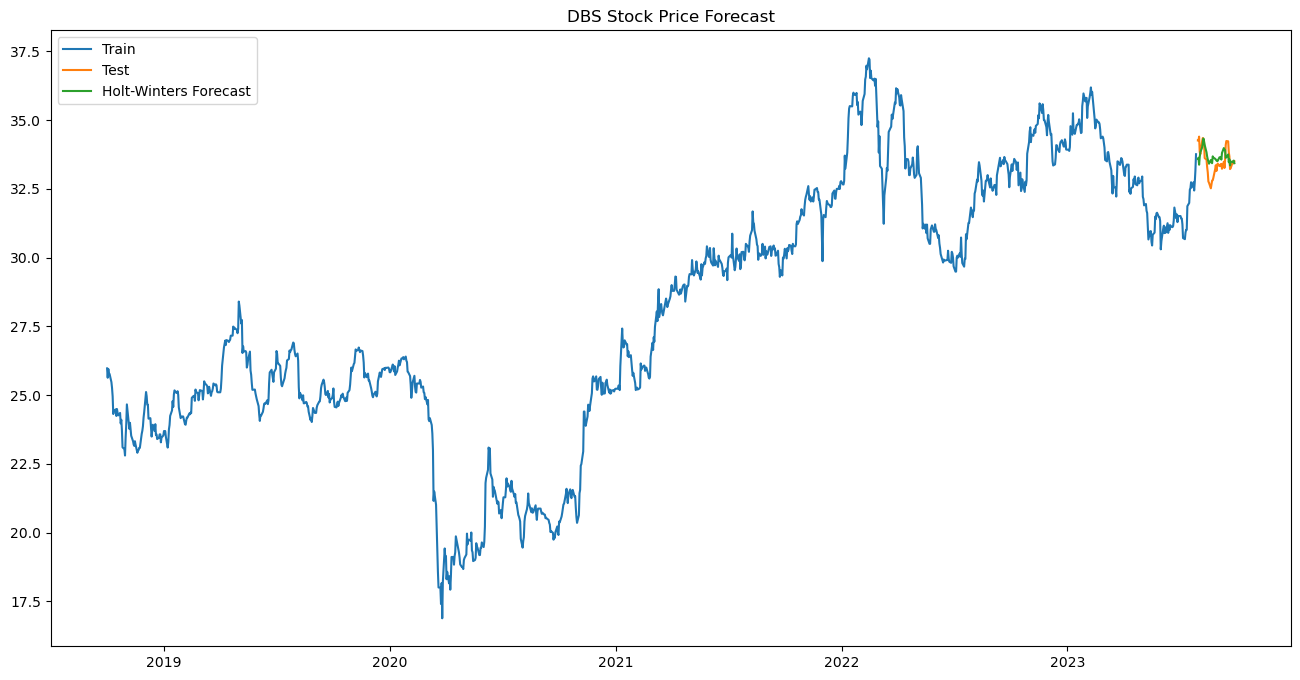

Apple Model MAPE on training data is 1.51%
Apple Model MAPE on testing data is 11.49%
Amazon Model MAPE on training data is 1.50%
Amazon Model MAPE on testing data is 3.34%
DBS Model MAPE on training data is 0.79%
DBS Model MAPE on testing data is 1.17%
Apple Model RMSE on training data is 2.08
Apple Model RMSE on testing data is 21.58
Amazon Model RMSE on training data is 2.48
Amazon Model RMSE on testing data is 5.95
DBS Model RMSE on training data is 0.29
DBS Model RMSE on testing data is 0.48


In [19]:
# Apply Holt-Winters Exponential Smoothing for 'Apple'
fit1 = ExponentialSmoothing(np.asarray(y_train['Apple']), seasonal_periods=260, trend='add', seasonal='add').fit()

# Forecast future values
y_hat = fit1.forecast(len(y_test))

# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(y_train['Apple'], label='Train')
plt.plot(y_test['Apple'], label='Test')
plt.plot(y_test.index, y_hat, label='Holt-Winters Forecast')
plt.legend(loc='best')
plt.title('Apple Stock Price Forecast')
plt.show()

# Apply Holt-Winters Exponential Smoothing for 'Amazon'
fit2 = ExponentialSmoothing(np.asarray(y_train['Amazon']), seasonal_periods=260, trend='add', seasonal='add').fit()

# Forecast future values for 'Amazon'
y_hat_amazon = fit2.forecast(len(y_test))

# Plot the results for 'Amazon'
plt.figure(figsize=(16, 8))
plt.plot(y_train['Amazon'], label='Train')
plt.plot(y_test['Amazon'], label='Test')
plt.plot(y_test.index, y_hat_amazon, label='Holt-Winters Forecast')
plt.legend(loc='best')
plt.title('Amazon Stock Price Forecast')
plt.show()

# Apply Holt-Winters Exponential Smoothing for 'DBS'
fit3 = ExponentialSmoothing(np.asarray(y_train['DBS']), seasonal_periods=260, trend='add', seasonal='add').fit()

# Forecast future values for 'DBS'
y_hat_dbs = fit3.forecast(len(y_test))

# Plot the results for 'DBS'
plt.figure(figsize=(16, 8))
plt.plot(y_train['DBS'], label='Train')
plt.plot(y_test['DBS'], label='Test')
plt.plot(y_test.index, y_hat_dbs, label='Holt-Winters Forecast')
plt.legend(loc='best')
plt.title('DBS Stock Price Forecast')
plt.show()

# Calculate MAPE for 'Apple'
mape_train_apple = mean_absolute_percentage_error(y_train['Apple'], fit1.fittedvalues)
mape_test_apple = mean_absolute_percentage_error(y_test['Apple'], y_hat)
print(f"Apple Model MAPE on training data is {mape_train_apple*100:.2f}%")
print(f"Apple Model MAPE on testing data is {mape_test_apple*100:.2f}%")

# Calculate MAPE for 'Amazon'
mape_train_amazon = mean_absolute_percentage_error(y_train['Amazon'], fit2.fittedvalues)
mape_test_amazon = mean_absolute_percentage_error(y_test['Amazon'], y_hat_amazon)
print(f"Amazon Model MAPE on training data is {mape_train_amazon*100:.2f}%")
print(f"Amazon Model MAPE on testing data is {mape_test_amazon*100:.2f}%")

# Calculate MAPE for 'DBS'
mape_train_dbs = mean_absolute_percentage_error(y_train['DBS'], fit3.fittedvalues)
mape_test_dbs = mean_absolute_percentage_error(y_test['DBS'], y_hat_dbs)
print(f"DBS Model MAPE on training data is {mape_train_dbs*100:.2f}%")
print(f"DBS Model MAPE on testing data is {mape_test_dbs*100:.2f}%")

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate RMSE for 'Apple'
rmse_train_apple = rmse(y_train['Apple'], fit1.fittedvalues)
rmse_test_apple = rmse(y_test['Apple'], y_hat)
print(f"Apple Model RMSE on training data is {rmse_train_apple:.2f}")
print(f"Apple Model RMSE on testing data is {rmse_test_apple:.2f}")

# Calculate RMSE for 'Amazon'
rmse_train_amazon = rmse(y_train['Amazon'], fit2.fittedvalues)
rmse_test_amazon = rmse(y_test['Amazon'], y_hat_amazon)
print(f"Amazon Model RMSE on training data is {rmse_train_amazon:.2f}")
print(f"Amazon Model RMSE on testing data is {rmse_test_amazon:.2f}")

# Calculate RMSE for 'DBS'
rmse_train_dbs = rmse(y_train['DBS'], fit3.fittedvalues)
rmse_test_dbs = rmse(y_test['DBS'], y_hat_dbs)
print(f"DBS Model RMSE on training data is {rmse_train_dbs:.2f}")
print(f"DBS Model RMSE on testing data is {rmse_test_dbs:.2f}")

***
Explaining the evaluators:

- MAPE (Mean Absolute Percentage Error):
    - It measures the average absolute percentage difference between the actual and predicted values. It's expressed as a percentage. Lower MAPE values indicate better accuracy.

- RMSE (Root Mean Square Error):
    - It measures the square root of the average of the squared differences between actual and predicted values. It's expressed in the same units as the predicted values. Lower RMSE values indicate better accuracy.

Evaluating each stock:

- Apple Model:

    - MAPE on training data: 1.51%
    - MAPE on testing data: 11.49%
    - RMSE on training data: 2.08
    - RMSE on testing data: 21.58
    - The MAPE on training data (1.51%) suggests that the model's predictions deviate from the actual values by an average of 1.51% on the training dataset. However, the MAPE on testing data (11.49%) is significantly higher, indicating that the model's performance decreases when applied to unseen data. Similarly, the RMSE on testing data (21.58) is substantially higher than on training data (2.08), indicating larger errors in predictions on the testing dataset compared to the training dataset. This suggests potential overfitting, where the model fits too closely to the training data and does not generalize well to new, unseen data.

- Amazon Model:

    - MAPE on training data: 1.50%
    - MAPE on testing data: 3.34%
    - RMSE on training data: 2.48
    - RMSE on testing data: 5.95
    - Similar to the Apple model, the Amazon model also exhibits a significant increase in MAPE and RMSE when applied to testing data compared to training data. The MAPE on testing data (3.34%) is notably higher than on training data (1.50%), indicating poorer performance on unseen data. The RMSE on testing data (5.95) is also higher than on training data (2.48), further indicating potential overfitting.

- DBS Model:

    - MAPE on training data: 0.79%
    - MAPE on testing data: 1.17%
    - RMSE on training data: 0.29
    - RMSE on testing data: 0.48
    - The DBS model demonstrates relatively low MAPE and RMSE on both training and testing data compared to the other models. The increase in MAPE and RMSE from training to testing data is smaller compared to the other models, suggesting better generalization ability. However, there is still a noticeable increase, indicating some degree of overfitting or a need for further optimization.

In summary, the results indicate varying degrees of model performance and potential overfitting across different stocks. Further analysis, such as feature selection, model tuning, or validation on additional datasets, may be necessary to improve the models' performance and generalization ability.
***

### Building a ARIMA forecast model

#### Without tuning of parameters

                               SARIMAX Results                                
Dep. Variable:                  Apple   No. Observations:                 1260
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2842.323
Date:                Fri, 09 Feb 2024   AIC                           5690.646
Time:                        11:40:04   BIC                           5706.060
Sample:                    10-01-2018   HQIC                          5696.439
                         - 07-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4243      0.262      1.619      0.106      -0.089       0.938
ma.L1         -0.4833      0.256     -1.890      0.059      -0.985       0.018
sigma2         5.3512      0.139     38.453      0.0

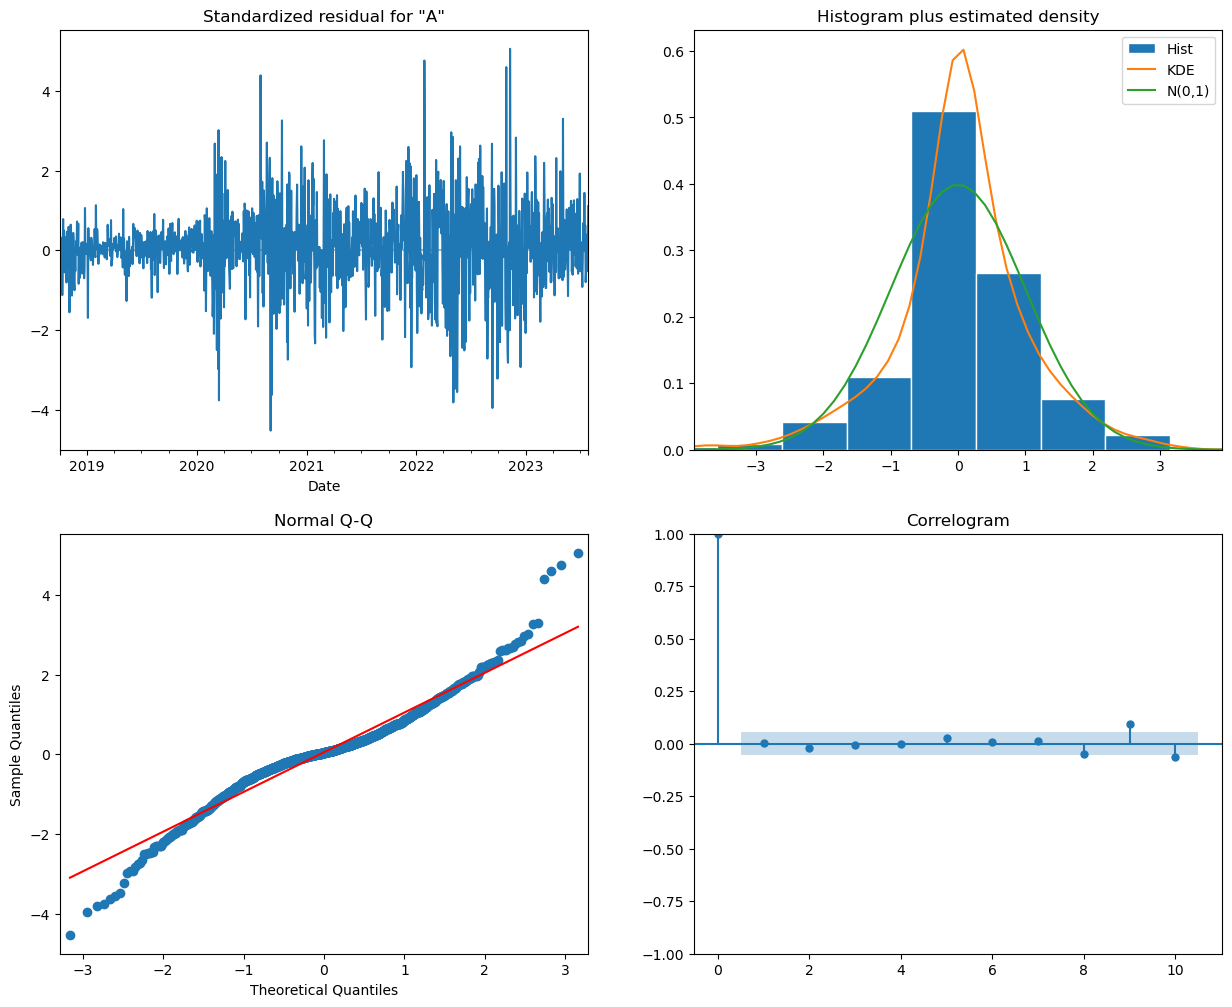

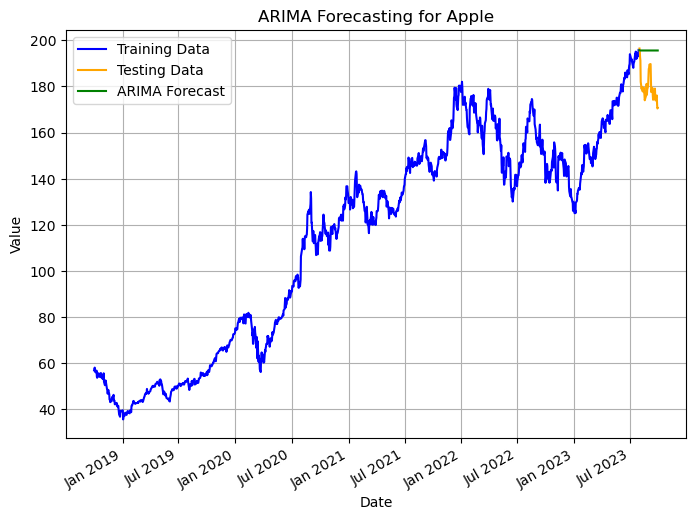

Root Mean Squared Error (RMSE) for Apple: 16.87
Mean Absolute Percentage Error (MAPE) for Apple: 8.82%

                               SARIMAX Results                                
Dep. Variable:                 Amazon   No. Observations:                 1260
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3080.667
Date:                Fri, 09 Feb 2024   AIC                           6167.333
Time:                        11:40:05   BIC                           6182.747
Sample:                    10-01-2018   HQIC                          6173.126
                         - 07-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6838      0.257     -2.660      0.008      -1.188      -0.180
ma.L1          0.6513      

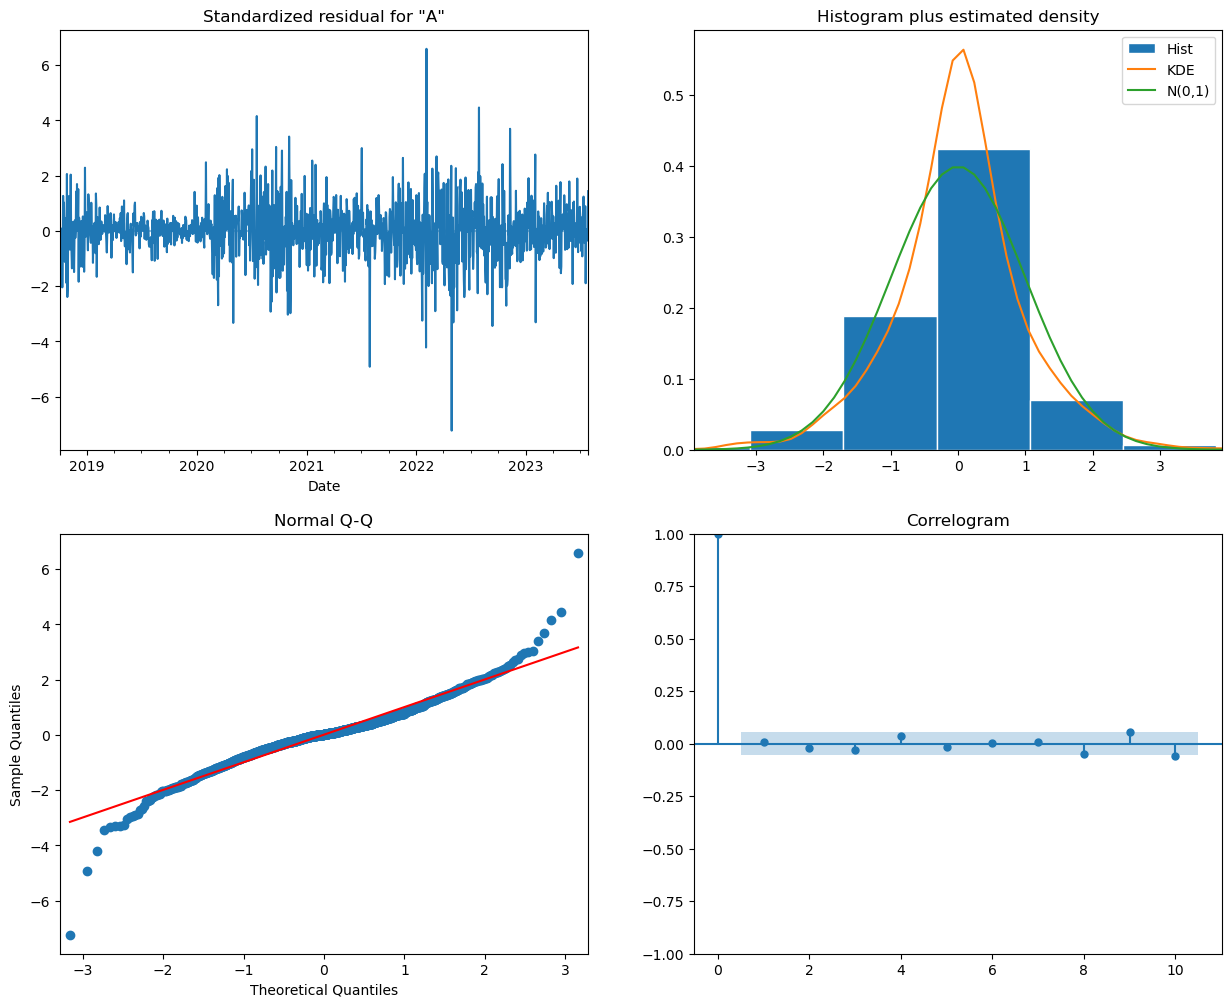

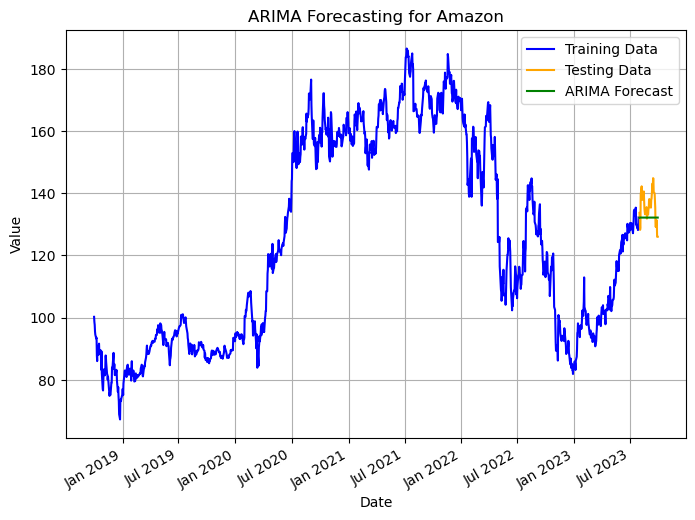

Root Mean Squared Error (RMSE) for Amazon: 5.91
Mean Absolute Percentage Error (MAPE) for Amazon: 3.65%

                               SARIMAX Results                                
Dep. Variable:                    DBS   No. Observations:                 1260
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -382.151
Date:                Fri, 09 Feb 2024   AIC                            770.302
Time:                        11:40:06   BIC                            785.716
Sample:                    10-01-2018   HQIC                           776.094
                         - 07-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7500      0.127      5.905      0.000       0.501       0.999
ma.L1         -0.7001     

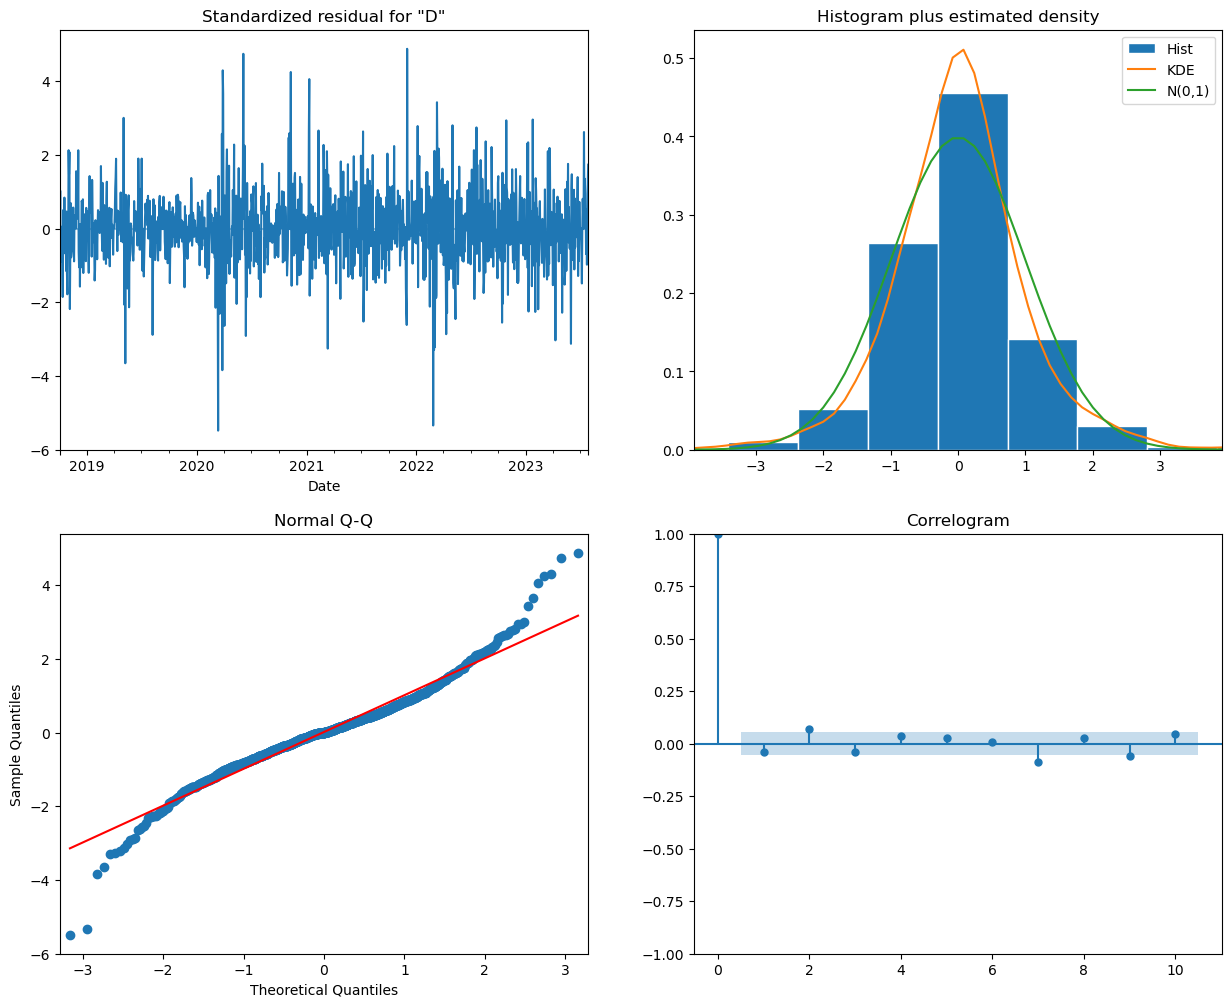

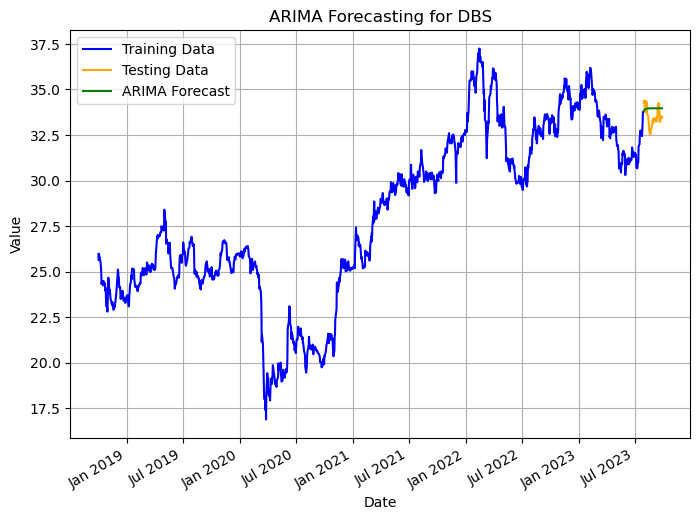

Root Mean Squared Error (RMSE) for DBS: 0.69
Mean Absolute Percentage Error (MAPE) for DBS: 1.81%



In [20]:
# Assuming business day frequency
stockPriceDateStationary_df.index = pd.to_datetime(stockPriceDateStationary_df.index, format='%m/%d/%Y')
df = stockPriceDateStationary_df.asfreq('B')

# Fill or interpolate missing values
df = df.interpolate(method='linear')

# Splitting the data into training and testing sets based on a specific date
train_data = df[df.index < '2023-07-30']
test_data = df[df.index >= '2023-07-30']

for column in df.columns:
    # Fit the ARIMA model on the training data
    model = ARIMA(train_data[column], order=(1, 1, 1)).fit()

    # Print the model summary
    print(model.summary())

    # Perform diagnostics
    model.plot_diagnostics(figsize=(15, 12))
    plt.show()

    # Forecast the next 60 days
    pred = model.get_prediction(start=test_data.index[0], end=test_data.index[-1])

    # Plot actual data, training data, and forecasts
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(train_data[column], label='Training Data', color='blue')  # Plotting training data
    ax.plot(test_data[column], label='Testing Data', color='orange')  # Plotting testing data

    # Generate dates for forecasted values starting from the day after the last date of actual data
    forecast_dates = pd.date_range(start=test_data.index[0], periods=len(test_data), freq='B')  # Ensure 60 periods

    # Plot forecasted values
    ax.plot(forecast_dates, pred.predicted_mean, label='ARIMA Forecast', color='green')

    ax.legend()
    ax.set_title("ARIMA Forecasting for " + column)
    ax.set_xlabel("Date")
    ax.set_ylabel("Value")
    ax.grid(True)

    # Set x-axis ticks to show every nth month
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Display 6 month
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as 'month year'

    fig.autofmt_xdate()  # Auto-adjust the x-axis dates so they don't overlap

    plt.show()

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test_data[column], pred.predicted_mean))
    print('Root Mean Squared Error (RMSE) for {}: {:.2f}'.format(column, rmse))

    # Calculate MAPE
    def mean_absolute_percentage_error(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    mape = mean_absolute_percentage_error(test_data[column], pred.predicted_mean)
    print('Mean Absolute Percentage Error (MAPE) for {}: {:.2f}%\n'.format(column, mape))

***
Here, we have performed Arima modeling without the tuning of parameters.

Key features we are looking out for:
- ARIMA Parameters (p, d, q):
    - p: Autoregressive (AR) order, which is 1 in this case. It represents the number of lagged observations included in the model.
    - d: Differencing order, also 1 in this case. It represents the number of differences needed to make the time series stationary.
    - q: Moving Average (MA) order, which is 1. It represents the number of lagged forecast errors included in the model.

- AIC, BIC:
   
    - AIC (Akaike Information Criterion): A goodness-of-fit measure that considers the model's complexity and penalizes for the number of parameters. Lower AIC indicates a better model fit.
    - BIC (Bayesian Information Criterion): Similar to AIC, but penalizes more for the number of parameters. Lower BIC indicates a better model fit.

Explaining the evaluations of the results:
- Apple:
    - Model ARIMA(1, 1, 1) is the order of the ARIMA model. In this case, it's an autoregressive integrated moving average model with AR order 1, differencing order 1, and MA order 1.
    - AIC is a measure of the model's goodness of fit, adjusted for the number of parameters. It is used for model selection, where lower values indicate a better fit. Here, it's 5690.646.
    - BIC is similar to AIC but penalizes for the number of parameters more severely. Like AIC, lower values of BIC indicate better model fit. Here, it's 5706.060.
    - An RMSE of 16.87 indicates that, on average, the ARIMA model's predictions for Apple stock prices are off by approximately $16.87.
    - A MAPE of 8.82% means that, on average, the ARIMA model's predictions for Apple stock prices deviate from the actual prices by approximately 8.82%.

- Amazon:
    - Model ARIMA(1, 1, 1) is the order of the ARIMA model. In this case, it's an autoregressive integrated moving average model with AR order 1, differencing order 1, and MA order 1.
    - AIC is a measure of the model's goodness of fit, adjusted for the number of parameters. It is used for model selection, where lower values indicate a better fit. Here, it's 6167.333.
    - BIC is similar to AIC but penalizes for the number of parameters more severely. Like AIC, lower values of BIC indicate better model fit. Here, it's 6182.747.
    - An RMSE of 5.91 indicates that, on average, the ARIMA model's predictions for Amazon stock prices are off by approximately $5.91.
    - A MAPE of 3.65% means that, on average, the ARIMA model's predictions for Amazon stock prices deviate from the actual prices by approximately 3.65%.

- DBS:
    - Model ARIMA(1, 1, 1) is the order of the ARIMA model. In this case, it's an autoregressive integrated moving average model with AR order 1, differencing order 1, and MA order 1.
    - AIC is a measure of the model's goodness of fit, adjusted for the number of parameters. It is used for model selection, where lower values indicate a better fit. Here, it's 770.302.
    - BIC is similar to AIC but penalizes for the number of parameters more severely. Like AIC, lower values of BIC indicate better model fit. Here, it's 785.716.
    - An RMSE of 0.69 indicates that, on average, the ARIMA model's predictions for DBS stock prices are off by approximately $0.69.
    - A MAPE of 1.81% means that, on average, the ARIMA model's predictions for DBS stock prices deviate from the actual prices by approximately 1.81%.        
***

#### With parameter tuning


Summary for Apple ARIMA Model:
                               SARIMAX Results                                
Dep. Variable:                  Apple   No. Observations:                 1260
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -2846.612
Date:                Fri, 09 Feb 2024   AIC                           5703.223
Time:                        11:40:15   BIC                           5728.918
Sample:                    10-01-2018   HQIC                          5712.879
                         - 07-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        113.9048     55.261      2.061      0.039       5.595     222.215
ar.L1          0.0548      0.027      2.020      0.043       0.002       0.108
ar.L2          0.943

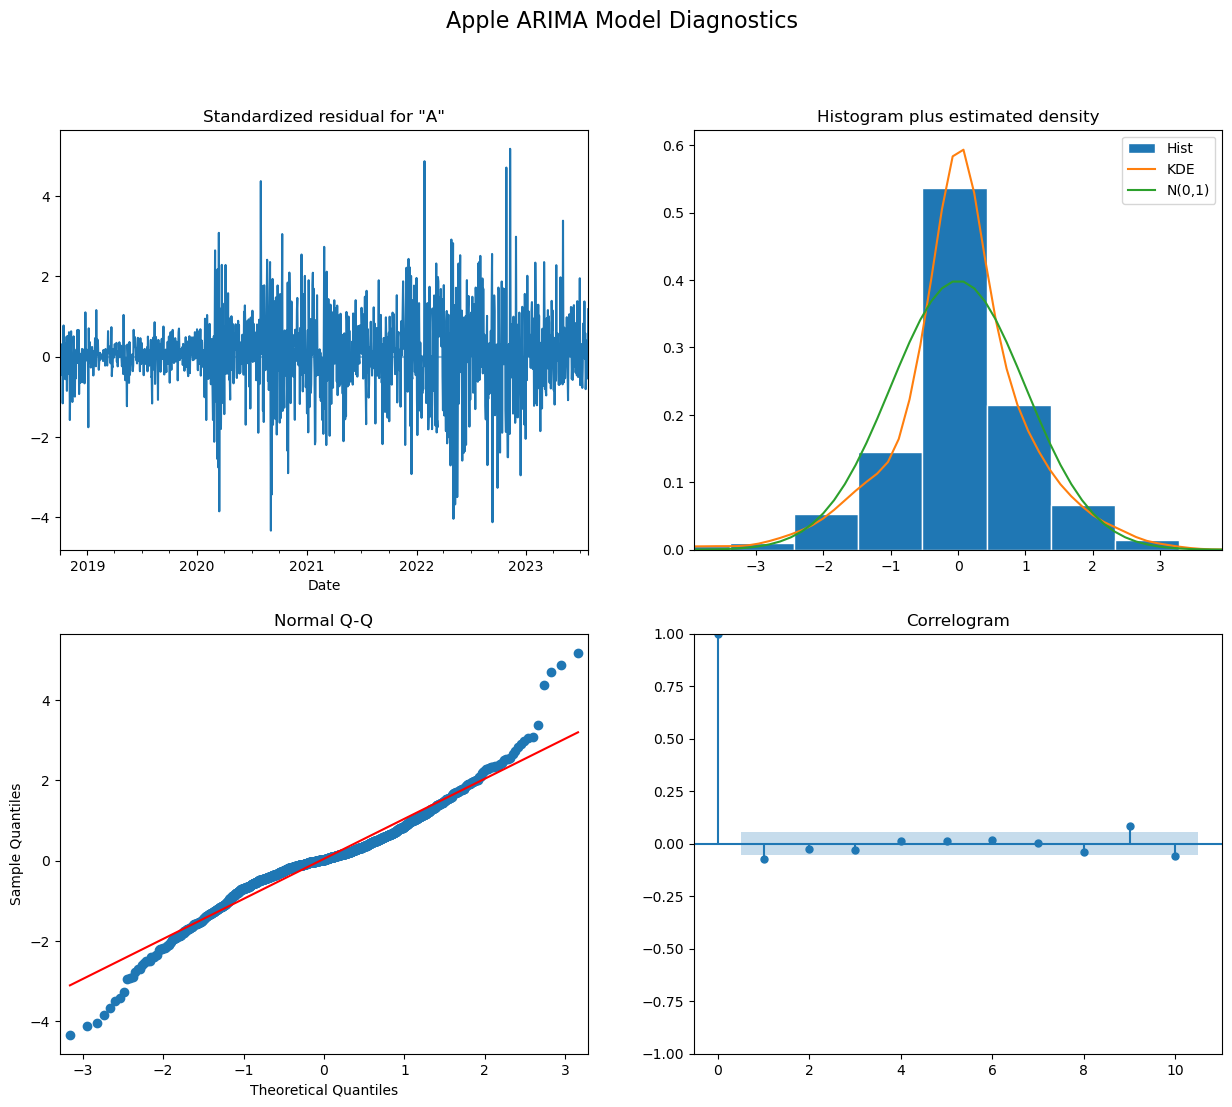

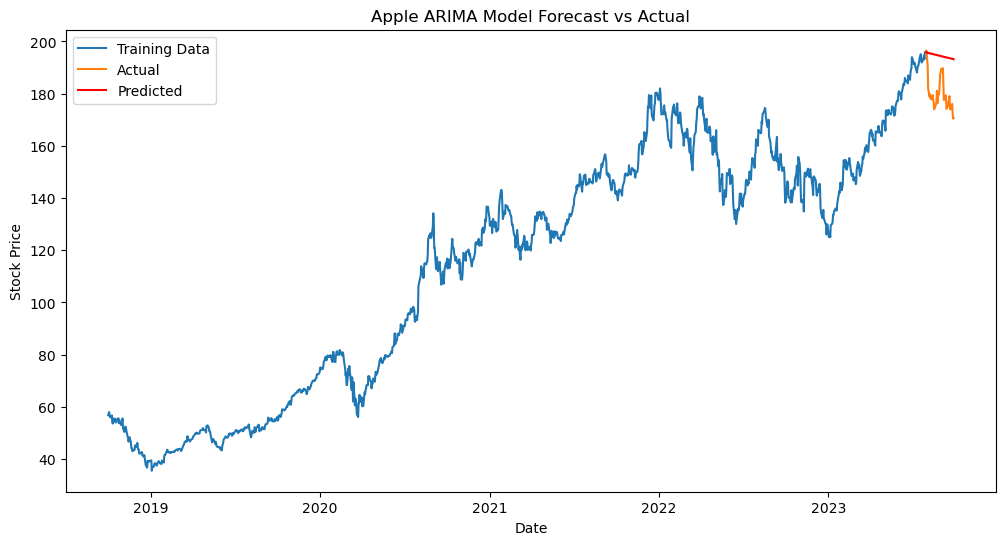

Best Root Mean Squared Error (RMSE): 15.71842177731597
Mean Absolute Percentage Error (MAPE) for Apple: 8.20%



c:\Users\caleb\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Summary for Amazon ARIMA Model:
                               SARIMAX Results                                
Dep. Variable:                 Amazon   No. Observations:                 1260
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -3083.107
Date:                Fri, 09 Feb 2024   AIC                           6174.215
Time:                        11:40:24   BIC                           6194.764
Sample:                    10-01-2018   HQIC                          6181.937
                         - 07-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9957      0.007   -143.964      0.000      -1.009      -0.982
ma.L1         -0.0020      1.224     -0.002      0.999      -2.401       2.398
ma.L2         -0.99

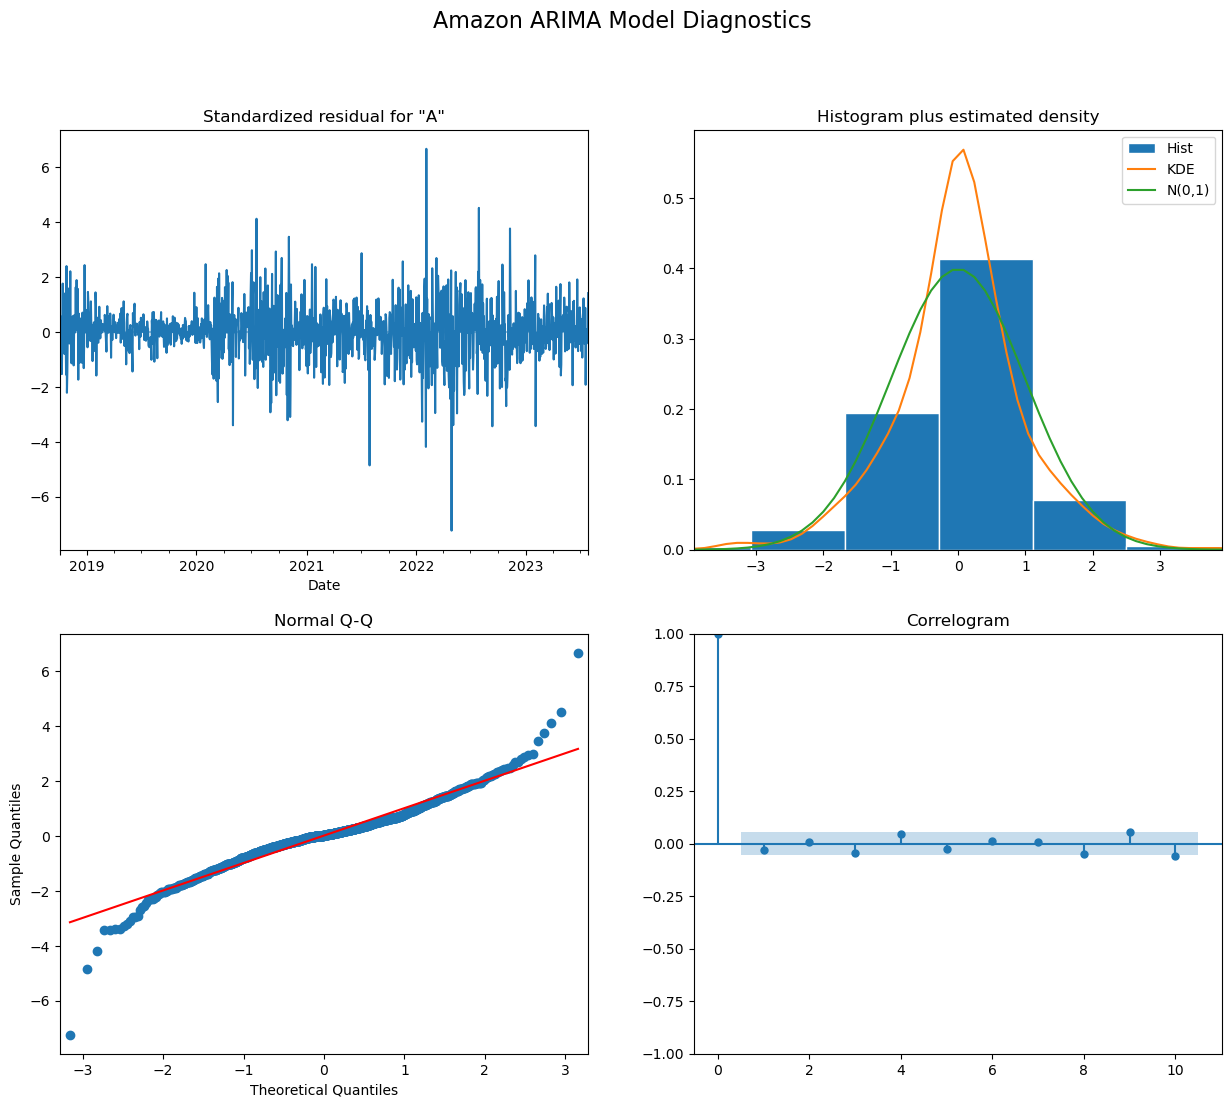

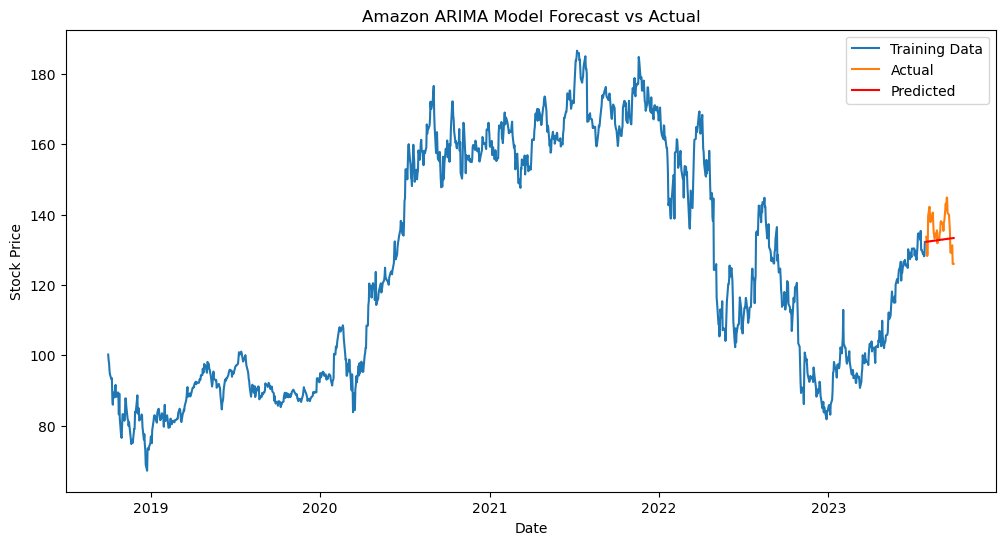

Best Root Mean Squared Error (RMSE): 5.596553135147475
Mean Absolute Percentage Error (MAPE) for Amazon: 3.45%


Summary for DBS ARIMA Model:
                               SARIMAX Results                                
Dep. Variable:                    DBS   No. Observations:                 1260
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -387.706
Date:                Fri, 09 Feb 2024   AIC                            783.413
Time:                        11:40:35   BIC                            803.968
Sample:                    10-01-2018   HQIC                           791.137
                         - 07-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.0058      4.423      6.332      0.000      19.337  

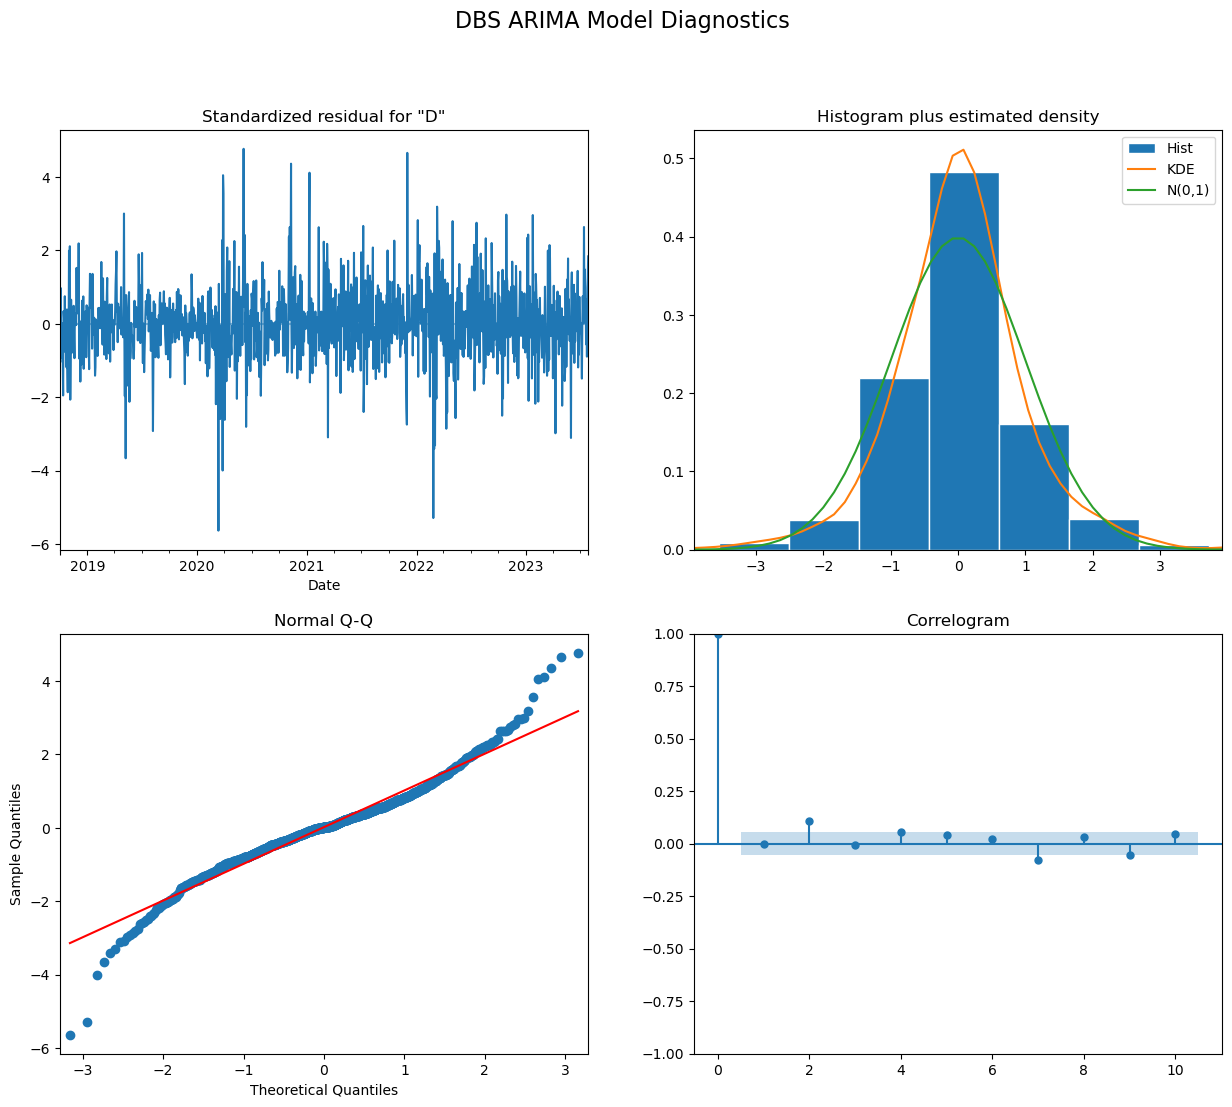

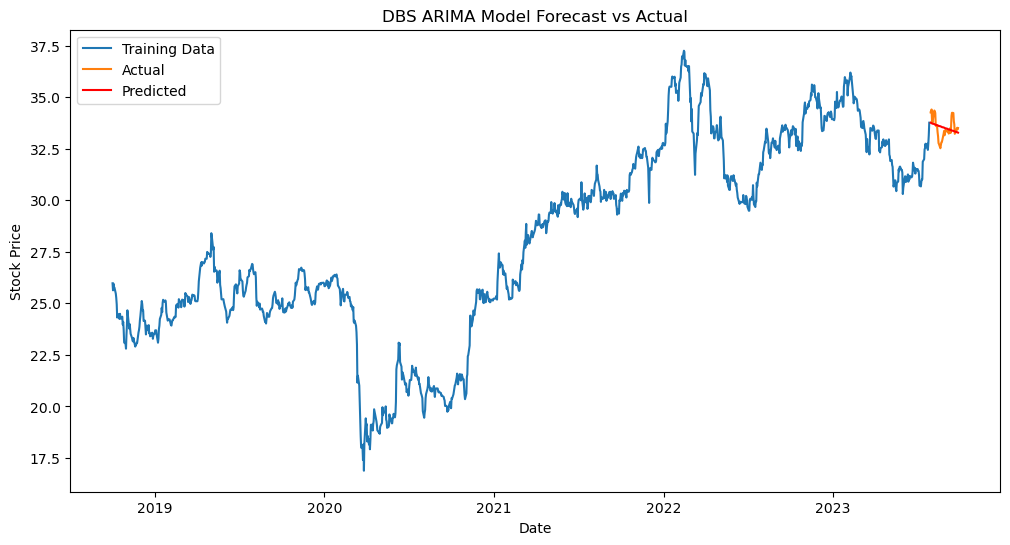

Best Root Mean Squared Error (RMSE): 0.4933850424275498
Mean Absolute Percentage Error (MAPE) for DBS: 1.17%



In [21]:
# Assuming business day frequency
stockPriceDateStationary_df.index = pd.to_datetime(stockPriceDateStationary_df.index, format='%m/%d/%Y')
df = stockPriceDateStationary_df.asfreq('B')

# Fill or interpolate missing values
df = df.interpolate(method='linear')

# Splitting the data into training and testing sets based on a specific date
train_data = df[df.index < '2023-07-30']
test_data = df[df.index >= '2023-07-30']

# Function to perform ARIMA modeling and prediction for a given stock
def arima_modeling(train_data, test_data, stock_name):
    # Define range of values for p, d, q
    p_values = range(0, 3)  # Example range for p
    d_values = range(0, 3)  # Example range for d
    q_values = range(0, 3)  # Example range for q

    # Initialize variables to store optimal values and corresponding RMSE
    best_rmse = float('inf')
    best_order = None

    # Perform grid search over the parameter space
    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            # Fit ARIMA model
            model = ARIMA(train_data[stock_name], order=(p, d, q))
            result = model.fit()

            # Make predictions on the testing set
            predictions = result.forecast(steps=len(test_data))

            # Calculate Mean Squared Error (MSE)
            mse = mean_squared_error(test_data[stock_name], predictions)

            # Calculate Root Mean Squared Error (RMSE)
            rmse = np.sqrt(mse)

            # Update best RMSE and order parameters if found a better combination
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = (p, d, q)
        except:
            continue

    # Fit ARIMA model with the best parameters
    best_model = ARIMA(train_data[stock_name], order=best_order)
    best_result = best_model.fit()

    # Print best model summary
    print(f"\nSummary for {stock_name} ARIMA Model:")
    print(best_result.summary())

    # Perform diagnostics
    best_result.plot_diagnostics(figsize=(15, 12))
    plt.suptitle(f'{stock_name} ARIMA Model Diagnostics', fontsize=16)
    plt.show()

    # Make predictions on the testing set using the best model
    best_predictions = best_result.forecast(steps=len(test_data))

    # Plot actual vs. predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(train_data[stock_name], label='Training Data')
    plt.plot(test_data.index, test_data[stock_name], label='Actual')
    plt.plot(test_data.index, best_predictions, color='red', label='Predicted')
    plt.title(f'{stock_name} ARIMA Model Forecast vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    # Print the best RMSE
    print('Best Root Mean Squared Error (RMSE):', best_rmse)

    # Calculate and print MAPE for testing data
    mape = mean_absolute_percentage_error(test_data[stock_name], best_predictions)
    print('Mean Absolute Percentage Error (MAPE) for {}: {:.2f}%\n'.format(stock_name, mape))

# Call the function for each stock
arima_modeling(train_data, test_data, 'Apple')
arima_modeling(train_data, test_data, 'Amazon')
arima_modeling(train_data, test_data, 'DBS')

***
We have successfully tuned the Arima model to different parameters among a range to find out the best parameters to use with the model. Usually we would use auto ARIMA in order to determine the parameters, however we cannot use it for CA2 and hence usage of inter.

Explaining the evaluations of the results:
- Apple:
    - Model ARIMA(2, 0, 1) is the order of the ARIMA model.
    - AIC is 5703.223, which increased from 5690.646.
    - BIC is 5728.918, which increased from 5706.060.
    - The RMSE deceased from 16.87 to 15.71 showing the model improved after tuning.
    - The MAPE decreased from 8.82% to 8.20% showing the model improved after tuning. 

- Amazon:
    - Model ARIMA(1, 2, 2) is the order of the ARIMA model.
    - AIC is 6174.215, which increased from 6167.333. 
    - BIC is 6194.764, which increased from 6182.747.
    - The RMSE decreased from 5.91 to 5.59 showing the model improved after tuning.
    - The MAPE decreased from 3.65% to 3.45% showing the model improved after tuning.
- DBS:
    - Model ARIMA(2, 0, 0) is the order of the ARIMA model.
    - AIC is 783.413, which decreased from 5690.646.
    - BIC is 803.968, which decreased from 5706.060.
    - The RMSE decreased from 0.69 to 0.49 showing the model improved after tuning.
    - The MAPE decreased from 1.81% to 1.17% showing the model improved after tuning.       
***

### Building a SARIMA forecast model

#### Without tuning of parameters

                                     SARIMAX Results                                      
Dep. Variable:                              Apple   No. Observations:                 1260
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2838.903
Date:                            Fri, 09 Feb 2024   AIC                           5687.806
Time:                                    11:40:37   BIC                           5713.448
Sample:                                10-01-2018   HQIC                          5697.447
                                     - 07-28-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4031      0.249      1.620      0.105      -0.085       0.891
ma.L1         -0.4670      0.242   

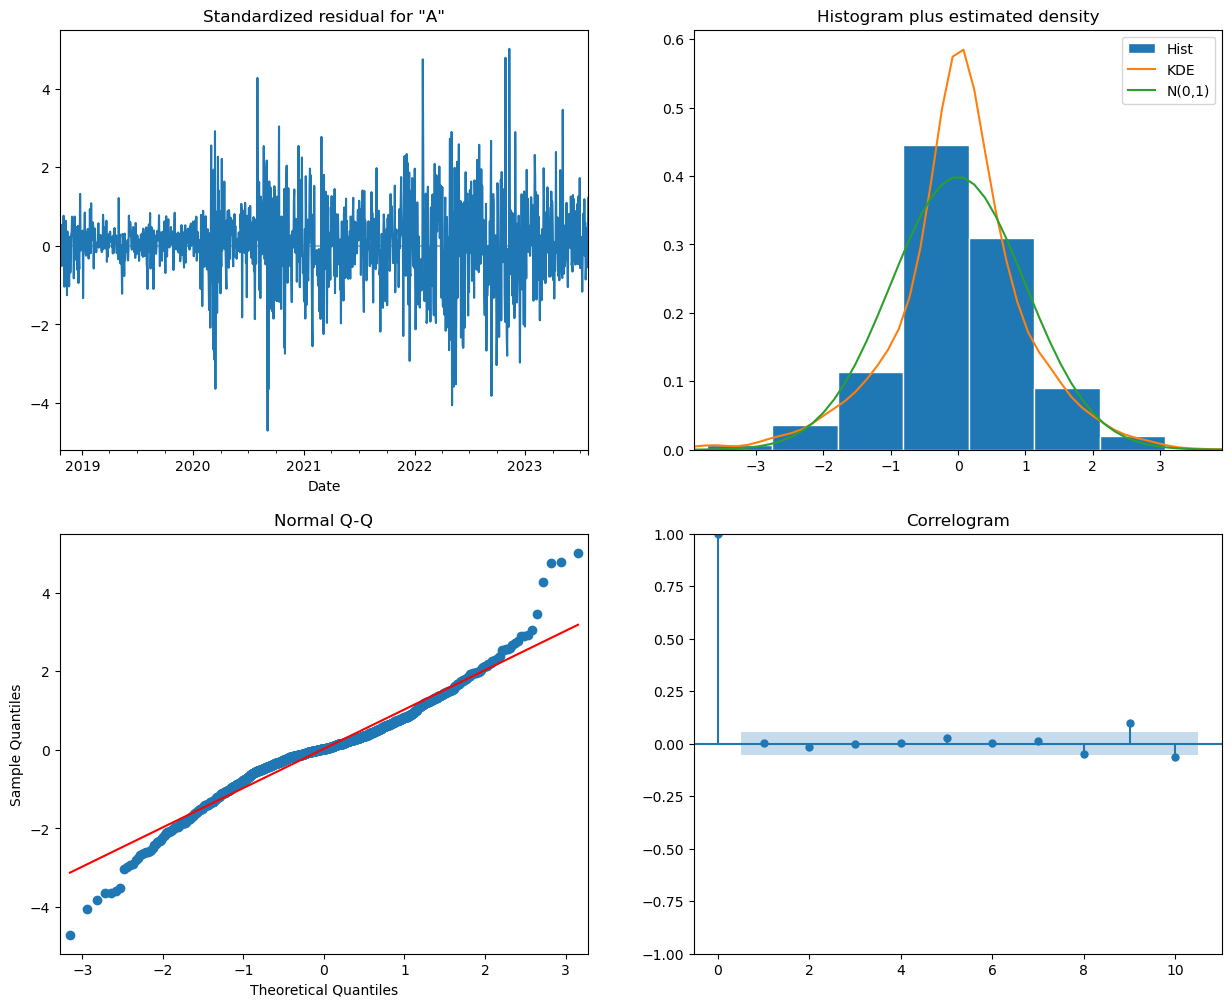

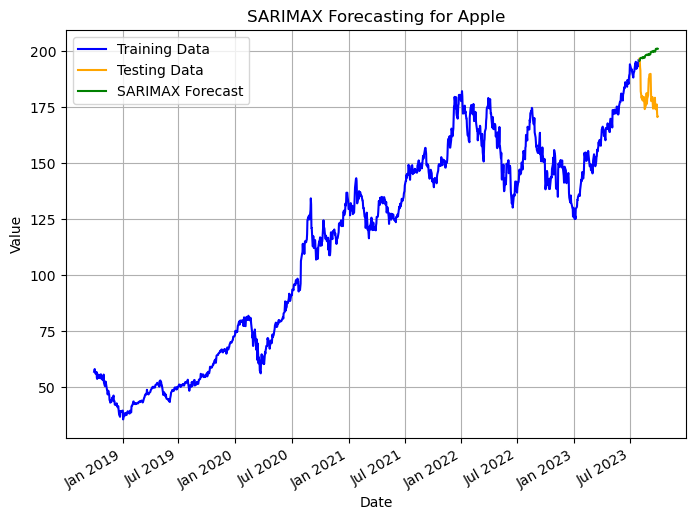

Root Mean Squared Error (RMSE) for Apple: 19.90
Mean Absolute Percentage Error (MAPE) for Apple: 10.44%

                                     SARIMAX Results                                      
Dep. Variable:                             Amazon   No. Observations:                 1260
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3077.750
Date:                            Fri, 09 Feb 2024   AIC                           6165.500
Time:                                    11:40:41   BIC                           6191.142
Sample:                                10-01-2018   HQIC                          6175.141
                                     - 07-28-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1    

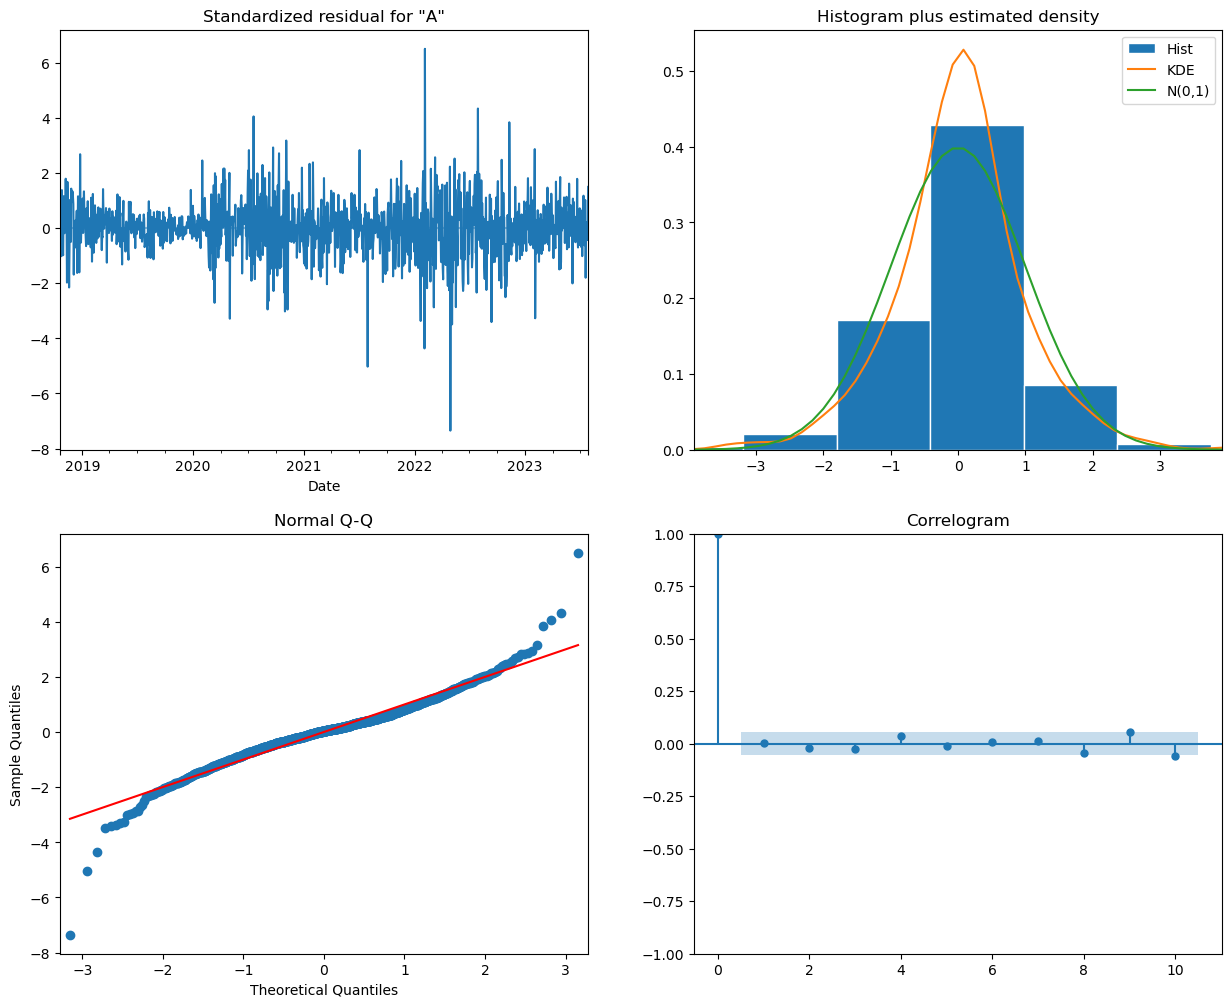

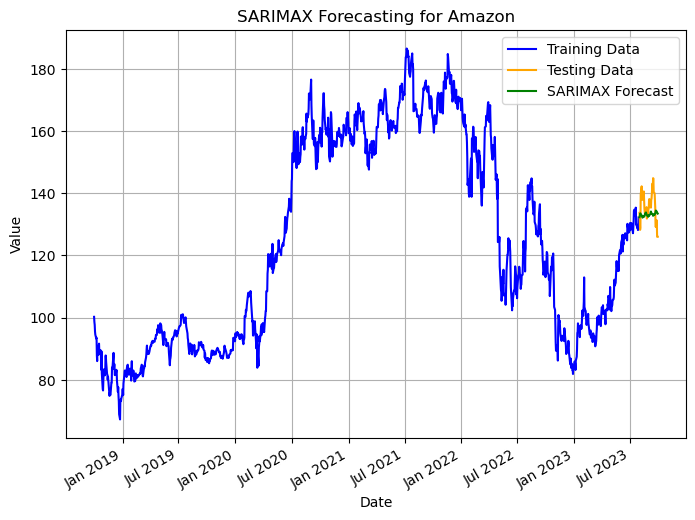

Root Mean Squared Error (RMSE) for Amazon: 5.59
Mean Absolute Percentage Error (MAPE) for Amazon: 3.42%

                                     SARIMAX Results                                      
Dep. Variable:                                DBS   No. Observations:                 1260
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -409.209
Date:                            Fri, 09 Feb 2024   AIC                            828.418
Time:                                    11:40:45   BIC                            854.061
Sample:                                10-01-2018   HQIC                           838.059
                                     - 07-28-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1    

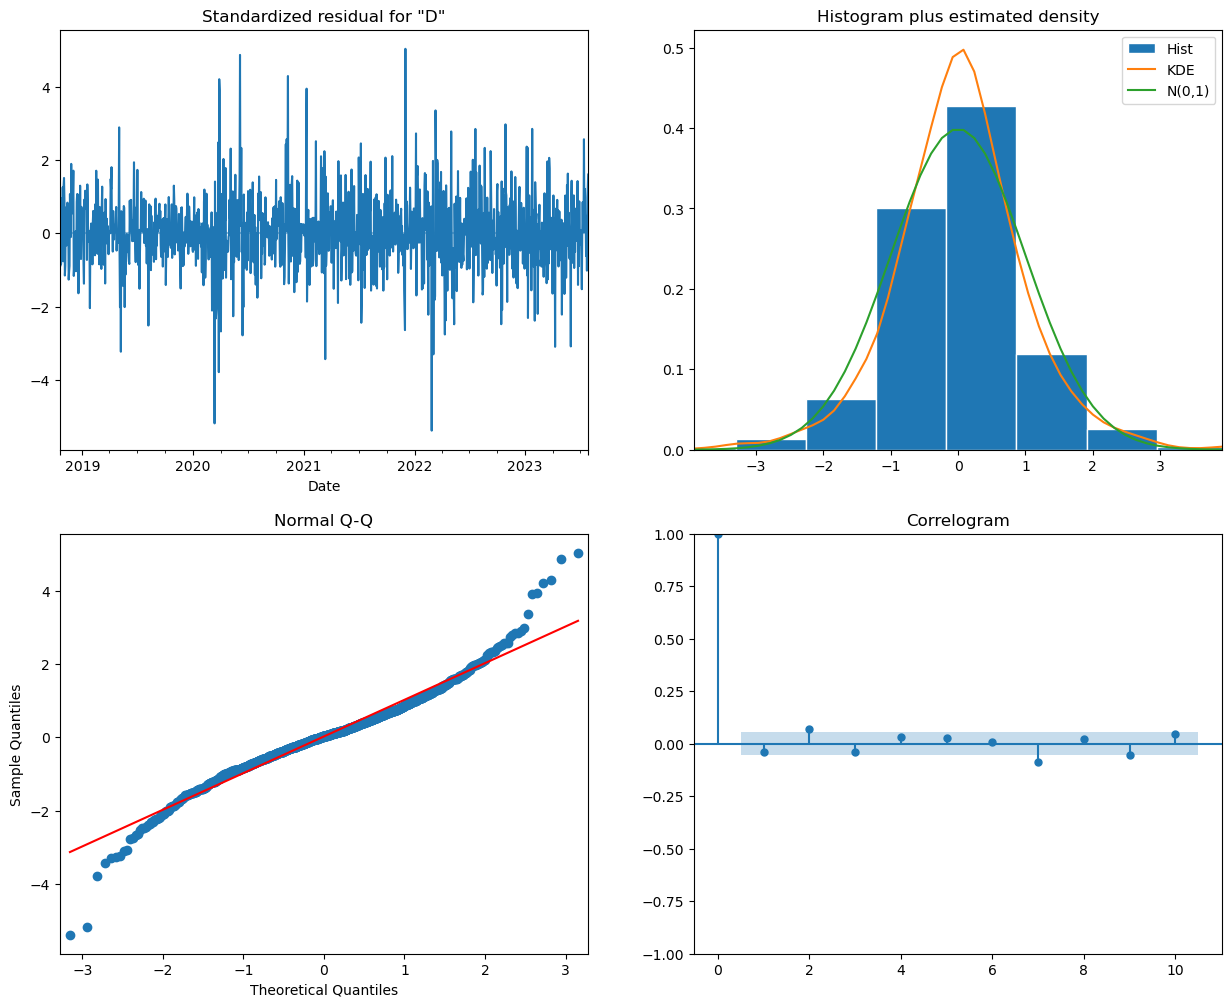

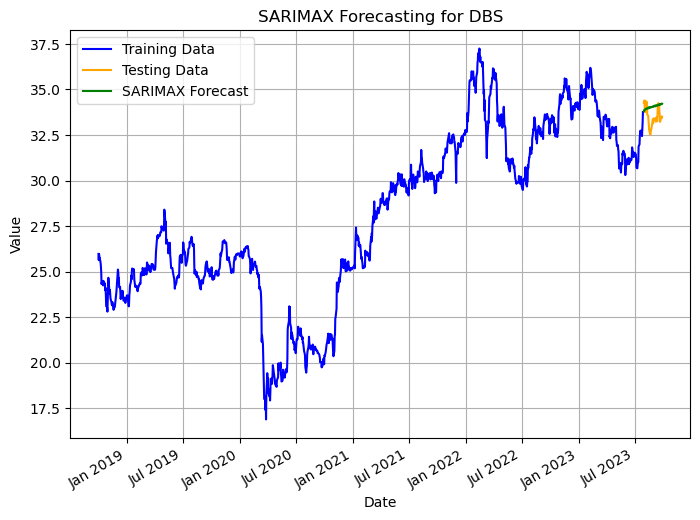

Root Mean Squared Error (RMSE) for DBS: 0.77
Mean Absolute Percentage Error (MAPE) for DBS: 2.05%



In [22]:
# Assuming business day frequency
stockPriceDateStationary_df.index = pd.to_datetime(stockPriceDateStationary_df.index, format='%m/%d/%Y')
df = stockPriceDateStationary_df.asfreq('B')

# Fill or interpolate missing values
df = df.interpolate(method='linear')

# Splitting the data into training and testing sets based on a specific date
train_data = df[df.index < '2023-07-30']
test_data = df[df.index >= '2023-07-30']

for column in df.columns:
    # Fit the SARIMAX model on the training data
    model = SARIMAX(train_data[column], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()

    # Print the model summary
    print(model.summary())

    # Perform diagnostics
    model.plot_diagnostics(figsize=(15, 12))
    plt.show()

    # Forecast the next 60 days
    pred = model.get_prediction(start=test_data.index[0], end=test_data.index[-1])

    # Plot actual data, training data, and forecasts
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(train_data[column], label='Training Data', color='blue')  # Plotting training data
    ax.plot(test_data[column], label='Testing Data', color='orange')  # Plotting testing data

    # Generate dates for forecasted values starting from the day after the last date of actual data
    forecast_dates = pd.date_range(start=test_data.index[0], periods=len(test_data), freq='B')  # Ensure 60 periods

    # Plot forecasted values
    ax.plot(forecast_dates, pred.predicted_mean, label='SARIMAX Forecast', color='green')

    ax.legend()
    ax.set_title("SARIMAX Forecasting for " + column)
    ax.set_xlabel("Date")
    ax.set_ylabel("Value")
    ax.grid(True)

    # Set x-axis ticks to show every nth month
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Display 6 month
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as 'month year'

    fig.autofmt_xdate()  # Auto-adjust the x-axis dates so they don't overlap

    plt.show()

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test_data[column], pred.predicted_mean))
    print('Root Mean Squared Error (RMSE) for {}: {:.2f}'.format(column, rmse))

    # Calculate MAPE
    def mean_absolute_percentage_error(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    mape = mean_absolute_percentage_error(test_data[column], pred.predicted_mean)
    print('Mean Absolute Percentage Error (MAPE) for {}: {:.2f}%\n'.format(column, mape))

***
Explaining the evaluations of the results:
- Apple:
    - Model SARIMAX(1, 1, 1)x(1, 1, 1, 12) is the order of the ARIMA model.
    - AIC is 5687.806.
    - BIC is 5713.448.
    - The RMSE is 19.90.
    - The MAPE is 10.44%.
    
- Amazon:
    - Model SARIMAX(1, 1, 1)x(1, 1, 1, 12) is the order of the ARIMA model.
    - AIC is 6165.500.
    - BIC is 6191.142.
    - The RMSE is 5.59.
    - The MAPE is 3.42%.
    
- DBS:
    - Model SARIMAX(1, 1, 1)x(1, 1, 1, 12) is the order of the ARIMA model.
    - AIC is 828.418.
    - BIC is 854.061.
    - The RMSE is 0.77.
    - The MAPE is 2.05%.     
***

#### With parameter tuning

c:\Users\caleb\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\caleb\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\caleb\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\caleb\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\caleb\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu


Summary for Apple SARIMAX Model:
                                      SARIMAX Results                                       
Dep. Variable:                                Apple   No. Observations:                 1260
Model:             SARIMAX(0, 0, 2)x(1, 1, [1], 12)   Log Likelihood               -3504.771
Date:                              Fri, 09 Feb 2024   AIC                           7019.543
Time:                                      11:45:34   BIC                           7045.189
Sample:                                  10-01-2018   HQIC                          7029.185
                                       - 07-28-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9786      0.022     45.290      0.000       0.9

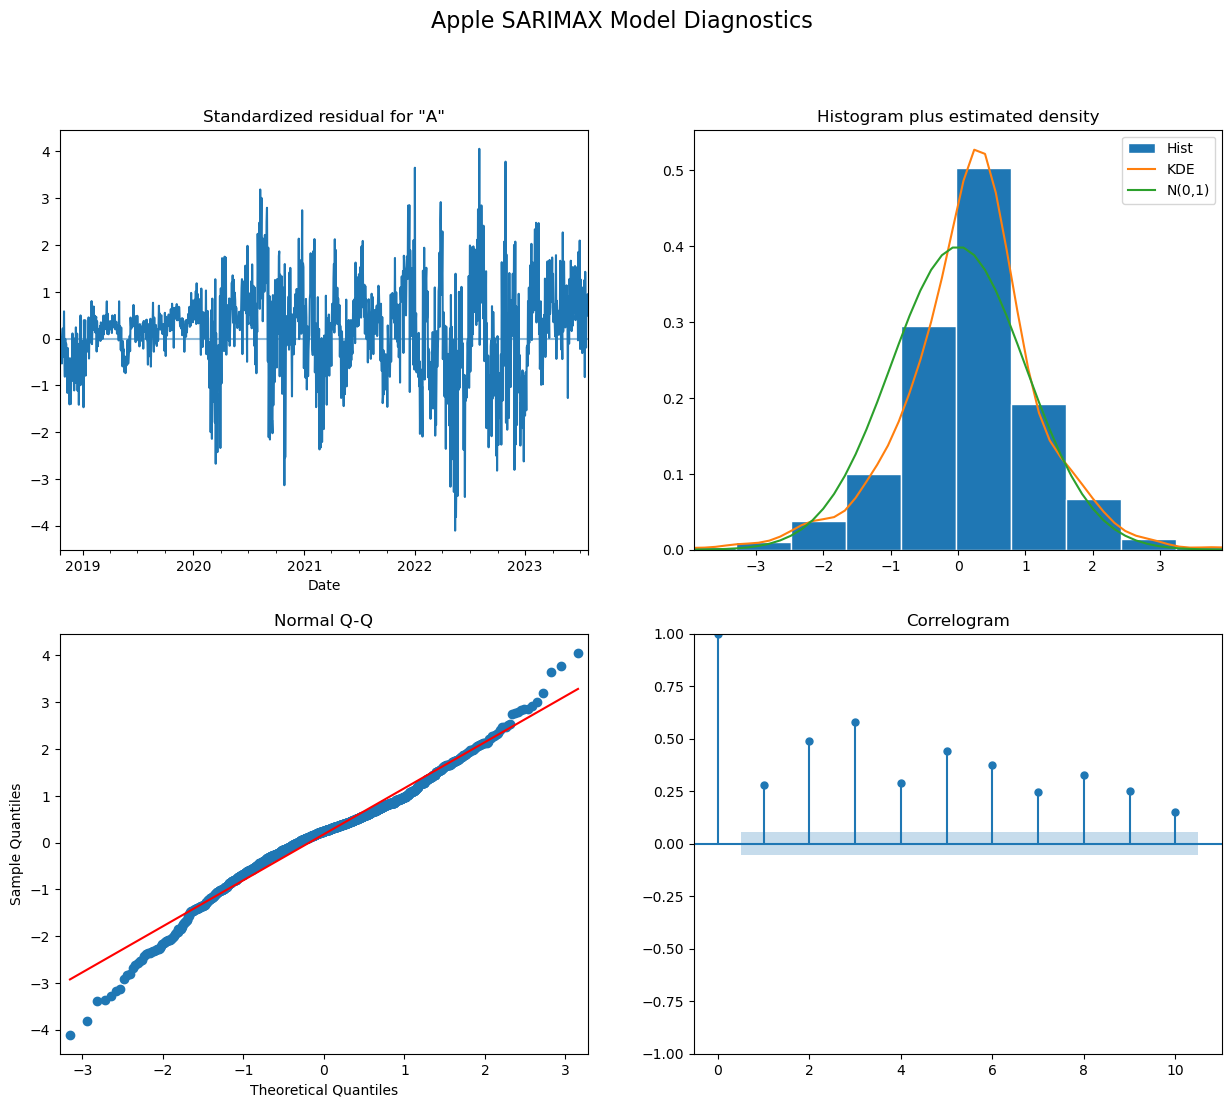

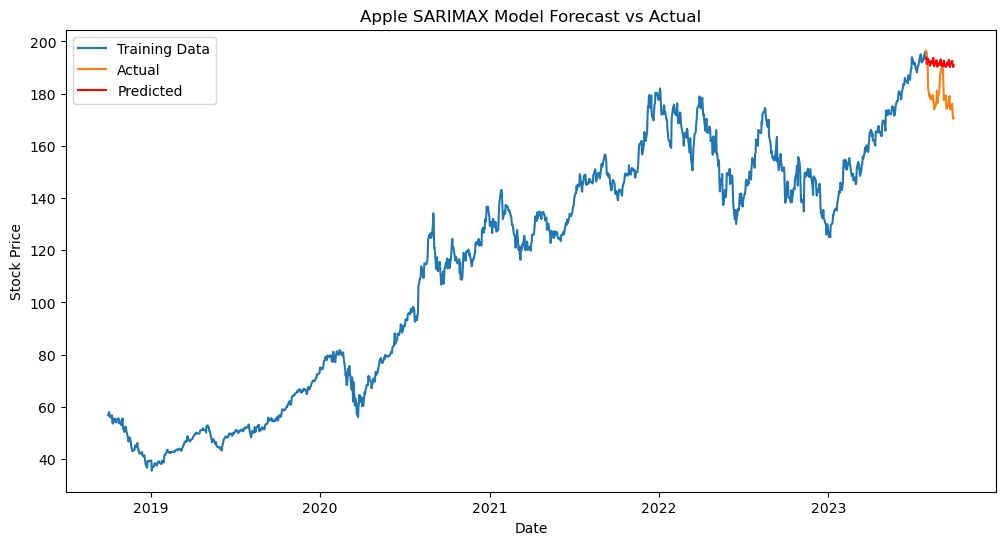

Best Root Mean Squared Error (RMSE): 13.184561494417038
Mean Absolute Percentage Error (MAPE) for Apple: 6.76%



c:\Users\caleb\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\caleb\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\caleb\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\caleb\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\caleb\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu


Summary for Amazon SARIMAX Model:
                                     SARIMAX Results                                      
Dep. Variable:                             Amazon   No. Observations:                 1260
Model:             SARIMAX(1, 2, 1)x(1, 1, 1, 12)   Log Likelihood               -3083.386
Date:                            Fri, 09 Feb 2024   AIC                           6176.772
Time:                                    11:50:46   BIC                           6202.410
Sample:                                10-01-2018   HQIC                          6186.411
                                     - 07-28-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0331      0.023     -1.432      0.152      -0.078       0.012


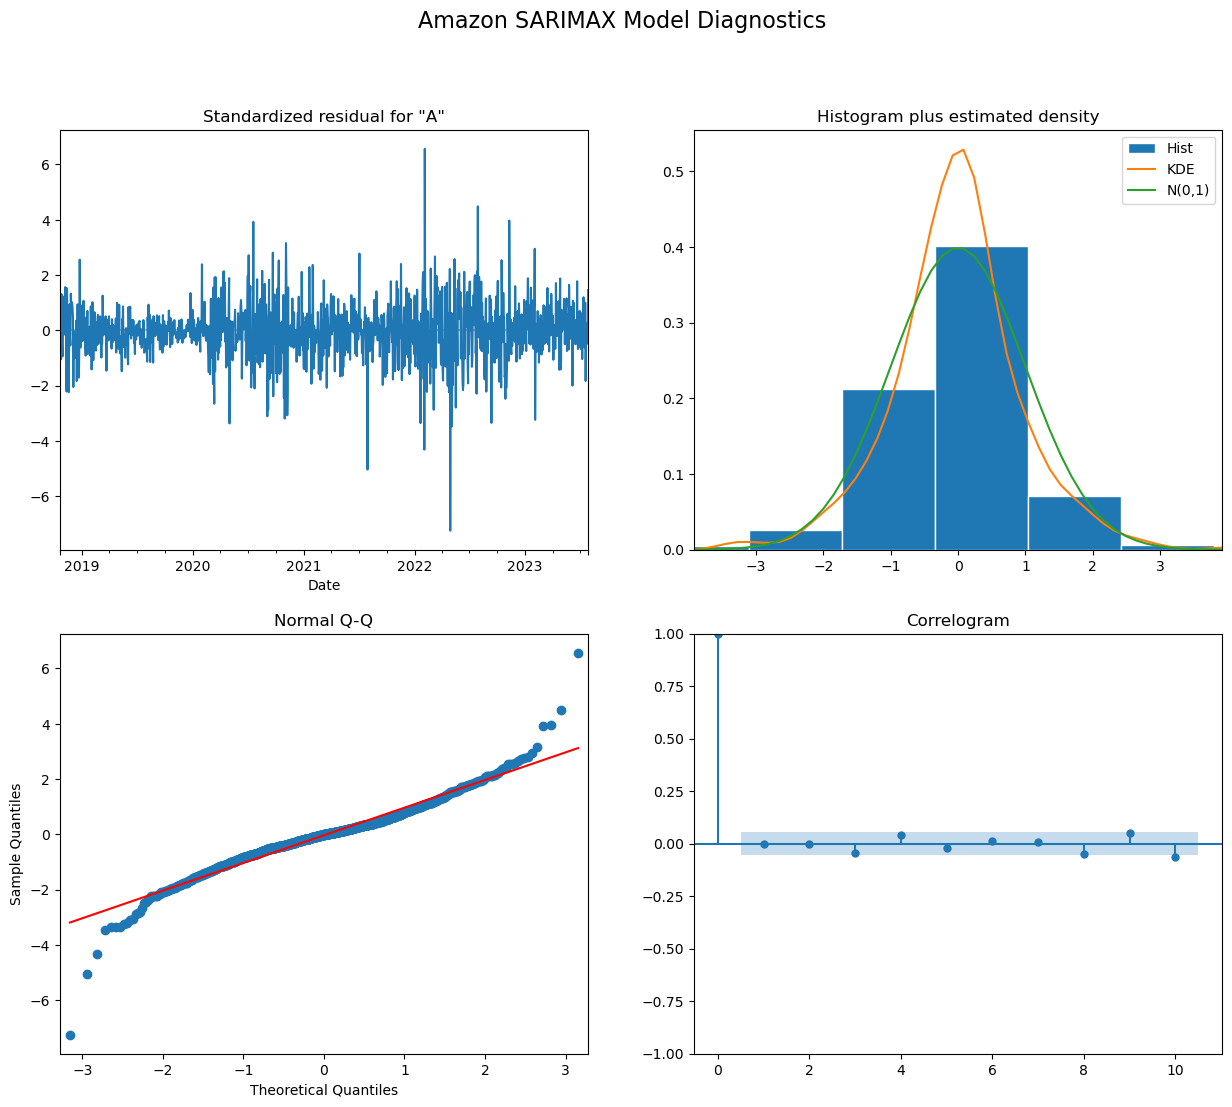

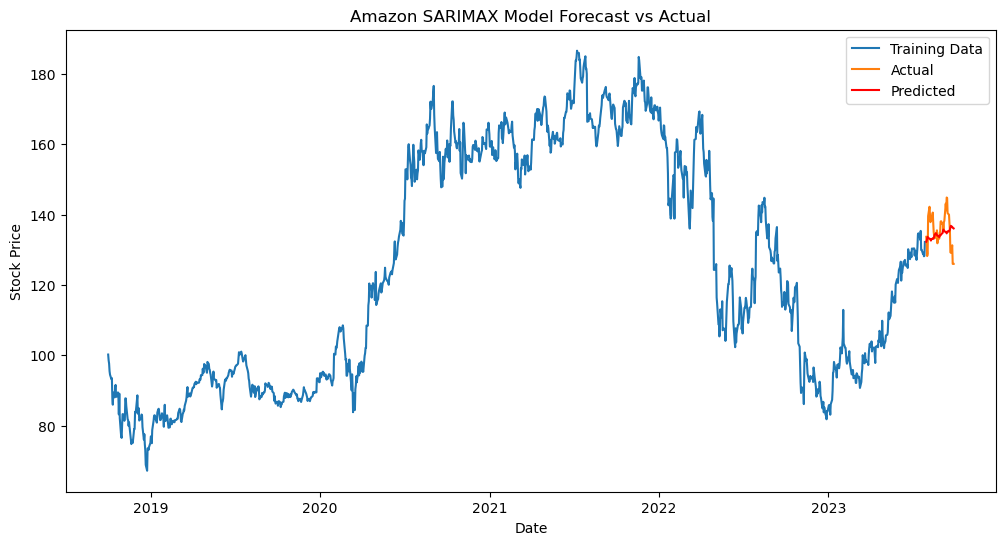

Best Root Mean Squared Error (RMSE): 5.3334657408650825
Mean Absolute Percentage Error (MAPE) for Amazon: 3.14%



c:\Users\caleb\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\caleb\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\caleb\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\caleb\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\caleb\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu


Summary for DBS SARIMAX Model:
                                      SARIMAX Results                                      
Dep. Variable:                                 DBS   No. Observations:                 1260
Model:             SARIMAX(2, 0, 2)x(1, 0, [], 12)   Log Likelihood                -385.226
Date:                             Fri, 09 Feb 2024   AIC                            782.451
Time:                                     11:56:35   BIC                            813.285
Sample:                                 10-01-2018   HQIC                           794.038
                                      - 07-28-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1041      0.052      2.003      0.045       0.002       0

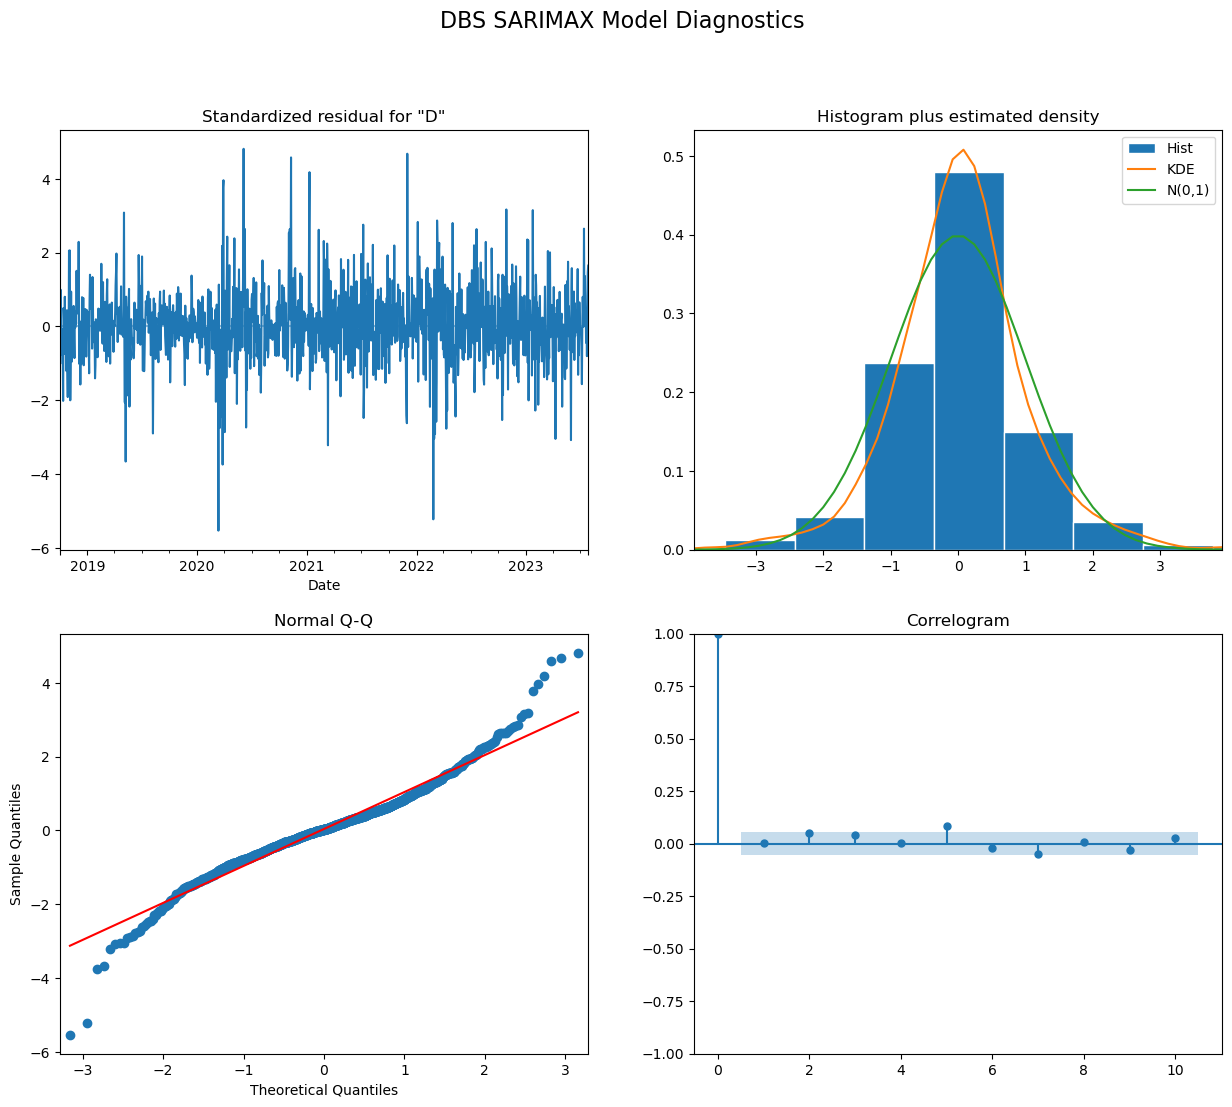

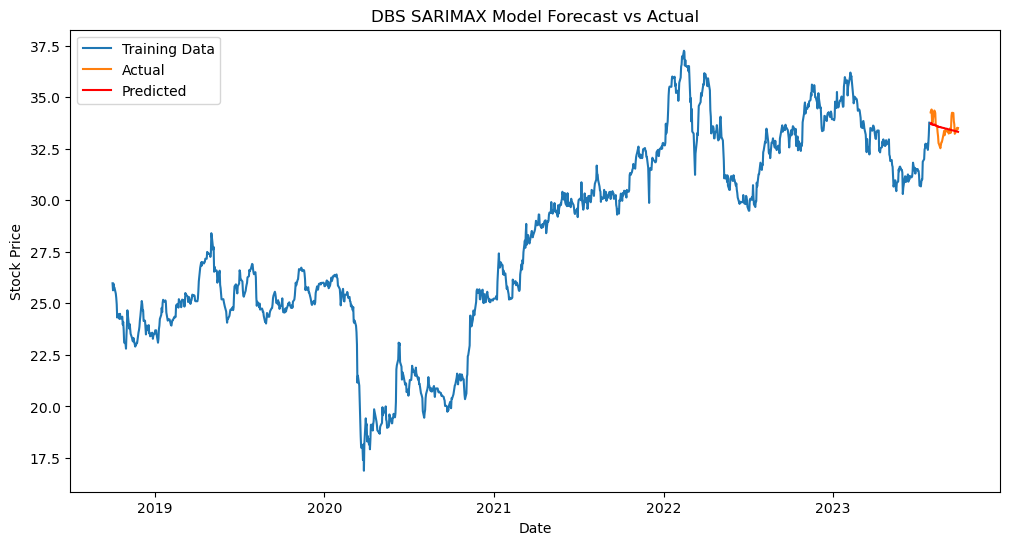

Best Root Mean Squared Error (RMSE): 0.48329894608964413
Mean Absolute Percentage Error (MAPE) for DBS: 1.14%



In [23]:
# Assuming business day frequency
stockPriceDateStationary_df.index = pd.to_datetime(stockPriceDateStationary_df.index, format='%m/%d/%Y')
df = stockPriceDateStationary_df.asfreq('B')

# Fill or interpolate missing values
df = df.interpolate(method='linear')

# Splitting the data into training and testing sets based on a specific date
train_data = df[df.index < '2023-07-30']
test_data = df[df.index >= '2023-07-30']

# Function to perform SARIMAX modeling and prediction for a given stock
def sarimax_modeling(train_data, test_data, stock_name):
    # Define range of values for p, d, q
    p_values = range(0, 3)  # Example range for p
    d_values = range(0, 3)  # Example range for d
    q_values = range(0, 3)  # Example range for q

    # Define range of values for seasonal p, d, q, and seasonal period
    seasonal_p_values = range(0, 2)  # Example range for seasonal p
    seasonal_d_values = range(0, 2)  # Example range for seasonal d
    seasonal_q_values = range(0, 2)  # Example range for seasonal q
    seasonal_periods = [12]  # Example seasonal period (monthly)

    # Initialize variables to store optimal values and corresponding RMSE
    best_rmse = float('inf')
    best_order = None
    best_seasonal_order = None

    # Perform grid search over the parameter space
    for p, d, q, sp, sd, sq in itertools.product(p_values, d_values, q_values, seasonal_p_values, seasonal_d_values, seasonal_q_values):
        try:
            # Fit SARIMAX model
            model = SARIMAX(train_data[stock_name], order=(p, d, q), seasonal_order=(sp, sd, sq, seasonal_periods[0]))
            result = model.fit()

            # Make predictions on the testing set
            predictions = result.forecast(steps=len(test_data))

            # Calculate Mean Squared Error (MSE)
            mse = mean_squared_error(test_data[stock_name], predictions)

            # Calculate Root Mean Squared Error (RMSE)
            rmse = np.sqrt(mse)

            # Update best RMSE and order parameters if found a better combination
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = (p, d, q)
                best_seasonal_order = (sp, sd, sq, seasonal_periods[0])
        except:
            continue

    # Fit SARIMAX model with the best parameters
    best_model = SARIMAX(train_data[stock_name], order=best_order, seasonal_order=best_seasonal_order)
    best_result = best_model.fit()

    # Print best model summary
    print(f"\nSummary for {stock_name} SARIMAX Model:")
    print(best_result.summary())

    # Perform diagnostics
    best_result.plot_diagnostics(figsize=(15, 12))
    plt.suptitle(f'{stock_name} SARIMAX Model Diagnostics', fontsize=16)
    plt.show()

    # Make predictions on the testing set using the best model
    best_predictions = best_result.forecast(steps=len(test_data))

    # Plot actual vs. predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(train_data[stock_name], label='Training Data')
    plt.plot(test_data.index, test_data[stock_name], label='Actual')
    plt.plot(test_data.index, best_predictions, color='red', label='Predicted')
    plt.title(f'{stock_name} SARIMAX Model Forecast vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    # Print the best RMSE
    print('Best Root Mean Squared Error (RMSE):', best_rmse)

    # Calculate and print MAPE for testing data
    mape = mean_absolute_percentage_error(test_data[stock_name], best_predictions)
    print('Mean Absolute Percentage Error (MAPE) for {}: {:.2f}%\n'.format(stock_name, mape))

# Call the function for each stock
sarimax_modeling(train_data, test_data, 'Apple')
sarimax_modeling(train_data, test_data, 'Amazon')
sarimax_modeling(train_data, test_data, 'DBS')

***
Explaining the evaluations of the results:
- Apple:
    - Model SARIMAX(0, 0, 2)x(1, 1, [1], 12) is the order of the ARIMA model.
    - AIC is 7019.543 which increased from 5687.806.
    - BIC is 7045.189 which increased from 5713.448.
    - The RMSE is 13.18 which decreased from 19.90 showing the model improved after tuning.
    - The MAPE is 6.76% which decreased from 10.44% showing the model improved after tuning.
    
- Amazon:
    - Model SARIMAX(1, 2, 1)x(1, 1, 1, 12) is the order of the ARIMA model.
    - AIC is 6176.772 which increased from 6165.500.
    - BIC is 6202.410 which increased from 6191.142.
    - The RMSE is 5.33 which decreased from 5.59 showing the model improved after tuning.
    - The MAPE is 3.14% which decreased from 3.42% showing the model improved after tuning.
    
- DBS:
    - Model SARIMAX(2, 0, 2)x(1, 0, [], 12) is the order of the ARIMA model.
    - AIC is 782.451 which decreased from 828.418.
    - BIC is 813.285 which decreased from 854.061.
    - The RMSE is 0.48 which decreased from 0.77 showing the model improved after tuning.
    - The MAPE is 1.14% which decreased from 2.05% showing the model improved after tuning.    
***

## Conclusion
***
Comparing all models RMSE and MAPE:

- SMA:
    - Apple:
        - RMSE: 15.0127 and MAPE: 7.79%
    - Amazon:
        - RMSE: 7.7852 and MAPE: 4.89%
    - DBS:
        - RMSE: 1.8195 and MAPE: 5.20%
- Holt-Winters Seasonal Method:
    - Apple:
        - RMSE: 21.58 and MAPE: 11.49%
    - Amazon:
        - RMSE: 5.95 and MAPE: 3.34%
    - DBS:
        - RMSE: 0.48 and MAPE: 1.17%
- Arima without tuning:
    - Apple:
        - RMSE: 16.87 and MAPE: 8.82%
    - Amazon:
        - RMSE: 5.91 and MAPE: 3.65%
    - DBS:
        - RMSE: 0.69 and MAPE: 1.81%
- Arima with tuning:
    - Apple:
        - RMSE: 15.7 and MAPE: 8.20%
    - Amazon:
        - RMSE: 5.59 and MAPE: 3.45%
    - DBS:
        - RMSE: 0.49 and MAPE: 1.17%
- Sarima without tuning:
    - Apple:
        - RMSE: 19.90 and MAPE: 10.44%
    - Amazon:
        - RMSE: 5.59 and MAPE: 3.42%
    - DBS:
        - RMSE: 0.77 and MAPE: 2.05%
- Sarima with tuning:
    - Apple:
        - RMSE: 13.18 and MAPE: 6.76%
    - Amazon:
        - RMSE: 5.33 and MAPE: 3.14%
    - DBS:
        - RMSE: 0.48 and MAPE: 1.14%


We have successfully built a forecasting model with the lowest RMSE and MAPE which indicates it is the best fit compared to the other models. The Sarima model parameters have been tuned to better fit the dataset.     

Hence, the best model for forecasting would be Sarima with parameter tuning. With the lowest RMSE and MAPE obtained from every stock, compared to other models, it is indeed the best model to be used for this scenario.                  
